# Report Failure Prediction - ML Midterm Zoomcamp Project

## Problem Description

This project predicts whether a report execution will fail or succeed in the PushMetrics platform.

**Business Context**: PushMetrics executes automated reports that:
- Query databases (BigQuery, Snowflake, MySQL, ClickHouse, etc.)
- Generate visualizations (Plotly, tables, KPI cards, Tableau Dashboards (png, pdf formats))
- Deliver results via email/Slack/cloud storage

**Why predict failures?**
- Proactively alert users about potential issues
- Optimize resource allocation (dynamically scale Kubernetes pods based on predicted load)
- Improve platform reliability
- Reduce customer support tickets

**ML Problem**: Binary classification
- Target: `failed` (0 = success, 1 = failure)
- Features: Report structure, historical performance, timing, database types
- Dataset: 440k report executions over 6 months
- Metric: ROC AUC (handles class imbalance)

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve

# for LogisticRegression tunning
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load and Explore Data

In [112]:
# Load data
df = pd.read_csv('report_executions.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns ({len(df.columns)}): {list(df.columns)}")

Dataset shape: (441810, 31)

Columns (31): ['failed', 'execution_id', 'report_hash', 'workspace_hash', 'num_blocks', 'num_sql_blocks', 'num_writeback_blocks', 'num_viz_blocks', 'num_tableau_blocks', 'num_email_blocks', 'num_slack_blocks', 'num_api_blocks', 'num_sftp_blocks', 'num_storage_blocks', 'num_control_blocks', 'num_parameters', 'num_databases', 'historical_failure_count', 'historical_executions', 'historical_failure_rate', 'avg_historical_duration', 'hours_since_last_success', 'hour_of_day', 'day_of_week', 'is_weekend', 'is_business_hours', 'is_rerun', 'is_scheduled', 'database_types', 'duration_seconds', 'execution_date']


In [113]:
# First few rows
df.head()

,failed,execution_id,report_hash,workspace_hash,num_blocks,num_sql_blocks,num_writeback_blocks,num_viz_blocks,num_tableau_blocks,num_email_blocks,...,hours_since_last_success,hour_of_day,day_of_week,is_weekend,is_business_hours,is_rerun,is_scheduled,database_types,duration_seconds,execution_date
0,0,1117318,d98c1545b7619bd99b817cb3169cdfde,8698ff92115213ab187d31d4ee5da8ea,6,2,0,0,0,0,...,0.264062,22,0,1,0,0,1,bigquery,4.270521,2025-11-09
1,0,1117317,cc3d69ed781b16bce06687822ae56e6d,8f125da0b3432ed853c0b6f7ee5aaa6b,0,0,0,0,0,0,...,0.161185,22,0,1,0,0,1,none,0.046462,2025-11-09
2,0,1117316,f7e0ef389ac6133c88aedbd66b44a4e1,921c2dc40d0b979c2910298d2f880152,10,1,0,0,4,1,...,167.984031,22,0,1,0,0,1,mssql,90.983180,2025-11-09
3,0,1117315,cc3d69ed781b16bce06687822ae56e6d,8f125da0b3432ed853c0b6f7ee5aaa6b,0,0,0,0,0,0,...,0.062391,22,0,1,0,0,1,none,0.044522,2025-11-09
4,0,1117314,853b722222dd0e45a9f94f2c799c949d,8698ff92115213ab187d31d4ee5da8ea,7,2,0,0,0,1,...,0.104361,22,0,1,0,0,1,bigquery,6.299606,2025-11-09


In [114]:
# Data types
df.dtypes

failed                        int64
execution_id                  int64
report_hash                  object
workspace_hash               object
num_blocks                    int64
num_sql_blocks                int64
num_writeback_blocks          int64
num_viz_blocks                int64
num_tableau_blocks            int64
num_email_blocks              int64
num_slack_blocks              int64
num_api_blocks                int64
num_sftp_blocks               int64
num_storage_blocks            int64
num_control_blocks            int64
num_parameters                int64
num_databases                 int64
historical_failure_count      int64
historical_executions         int64
historical_failure_rate     float64
avg_historical_duration     float64
hours_since_last_success    float64
hour_of_day                   int64
day_of_week                   int64
is_weekend                    int64
is_business_hours             int64
is_rerun                      int64
is_scheduled                

In [115]:
# Basic statistics
df.describe()

,failed,execution_id,num_blocks,num_sql_blocks,num_writeback_blocks,num_viz_blocks,num_tableau_blocks,num_email_blocks,num_slack_blocks,num_api_blocks,...,historical_failure_rate,avg_historical_duration,hours_since_last_success,hour_of_day,day_of_week,is_weekend,is_business_hours,is_rerun,is_scheduled,duration_seconds
count,441810.000000,4.418100e+05,441810.00000,441810.000000,441810.000000,441810.000000,441810.000000,441810.000000,441810.000000,441810.000000,...,441810.000000,441810.000000,4.309340e+05,441810.000000,441810.000000,441810.000000,441810.000000,441810.000000,441810.000000,414722.000000
mean,0.061311,8.939937e+05,7.69285,1.929381,0.031047,0.004900,1.133035,0.364141,0.753254,0.000754,...,0.063908,27.995052,2.853308e+01,11.263113,2.967964,0.270675,0.442376,0.008719,0.942899,27.311380
std,0.239901,1.286420e+05,10.55536,7.898630,0.291941,0.157247,2.797528,0.569960,1.018670,0.027444,...,0.205479,91.368870,1.603514e+02,6.268342,1.978931,0.444309,0.496669,0.092966,0.232037,105.041696
min,0.000000,6.708720e+05,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.133333e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027814
25%,0.000000,7.828432e+05,4.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,4.656298,2.627562e-01,6.000000,1.000000,0.000000,0.000000,0.000000,1.000000,3.964111
50%,0.000000,8.938570e+05,6.00000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000763,6.848460,9.990692e-01,11.000000,3.000000,0.000000,0.000000,0.000000,1.000000,5.638005
75%,0.000000,1.004848e+06,8.00000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.016301,23.282772,2.397645e+01,16.000000,5.000000,1.000000,1.000000,0.000000,1.000000,19.236815
max,1.000000,1.117318e+06,186.00000,181.000000,11.000000,7.000000,66.000000,10.000000,24.000000,1.000000,...,1.000000,3331.181852,4.296011e+03,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000,3650.789873


In [116]:
# Check for missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Missing': missing,
    'Percentage': missing_pct
})

print("Missing values:")
print(missing_df[missing_df['Missing'] > 0].sort_values('Missing', ascending=False))

Missing values:
                          Missing  Percentage
duration_seconds            27088        6.13
hours_since_last_success    10876        2.46


## 2. Target Variable Analysis

Understanding class distribution is crucial for binary classification.

In [117]:
# Class distribution
print("Target variable distribution:")
print(df['failed'].value_counts())
print(f"\nPercentage:")
print(df['failed'].value_counts(normalize=True) * 100)

failure_rate = df['failed'].mean() * 100
print(f"\nOverall failure rate: {failure_rate:.2f}%")

Target variable distribution:
0    414722
1     27088
Name: failed, dtype: int64

Percentage:
0    93.868858
1     6.131142
Name: failed, dtype: float64

Overall failure rate: 6.13%


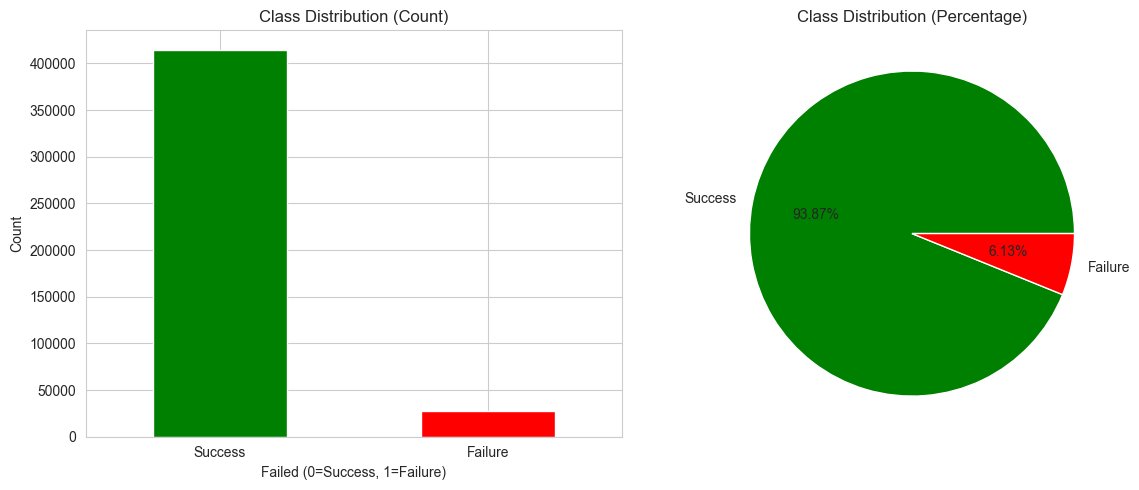

In [118]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
df['failed'].value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution (Count)')
axes[0].set_xlabel('Failed (0=Success, 1=Failure)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Success', 'Failure'], rotation=0)

# Pie chart
df['failed'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                                  labels=['Success', 'Failure'], colors=['green', 'red'])
axes[1].set_title('Class Distribution (Percentage)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

## 3. Feature Analysis

Let's identify feature types and understand their distributions.

In [119]:
# Identify feature columns
# Exclude: identifiers, target, and post-execution features
exclude_cols = [
    'execution_id',      # report run identifier
    'report_hash',       # report identifier
    'workspace_hash',    # workspace identifier
    'duration_seconds',  # only available after execution
    'execution_date',    # for train/test split
    'failed'             # target variable
]

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

Total features: 25

Feature list:
 1. num_blocks
 2. num_sql_blocks
 3. num_writeback_blocks
 4. num_viz_blocks
 5. num_tableau_blocks
 6. num_email_blocks
 7. num_slack_blocks
 8. num_api_blocks
 9. num_sftp_blocks
10. num_storage_blocks
11. num_control_blocks
12. num_parameters
13. num_databases
14. historical_failure_count
15. historical_executions
16. historical_failure_rate
17. avg_historical_duration
18. hours_since_last_success
19. hour_of_day
20. day_of_week
21. is_weekend
22. is_business_hours
23. is_rerun
24. is_scheduled
25. database_types


In [120]:
# Separate numerical and categorical features
numerical_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [col for col in feature_cols if col not in numerical_features]

print(f"Numerical features ({len(numerical_features)}):")
for f in numerical_features:
    print(f"  - {f}")

print(f"\nCategorical features ({len(categorical_features)}):")
for f in categorical_features:
    print(f"  - {f}")

Numerical features (24):
  - num_blocks
  - num_sql_blocks
  - num_writeback_blocks
  - num_viz_blocks
  - num_tableau_blocks
  - num_email_blocks
  - num_slack_blocks
  - num_api_blocks
  - num_sftp_blocks
  - num_storage_blocks
  - num_control_blocks
  - num_parameters
  - num_databases
  - historical_failure_count
  - historical_executions
  - historical_failure_rate
  - avg_historical_duration
  - hours_since_last_success
  - hour_of_day
  - day_of_week
  - is_weekend
  - is_business_hours
  - is_rerun
  - is_scheduled

Categorical features (1):
  - database_types


## 4. Numerical Feature Distribution

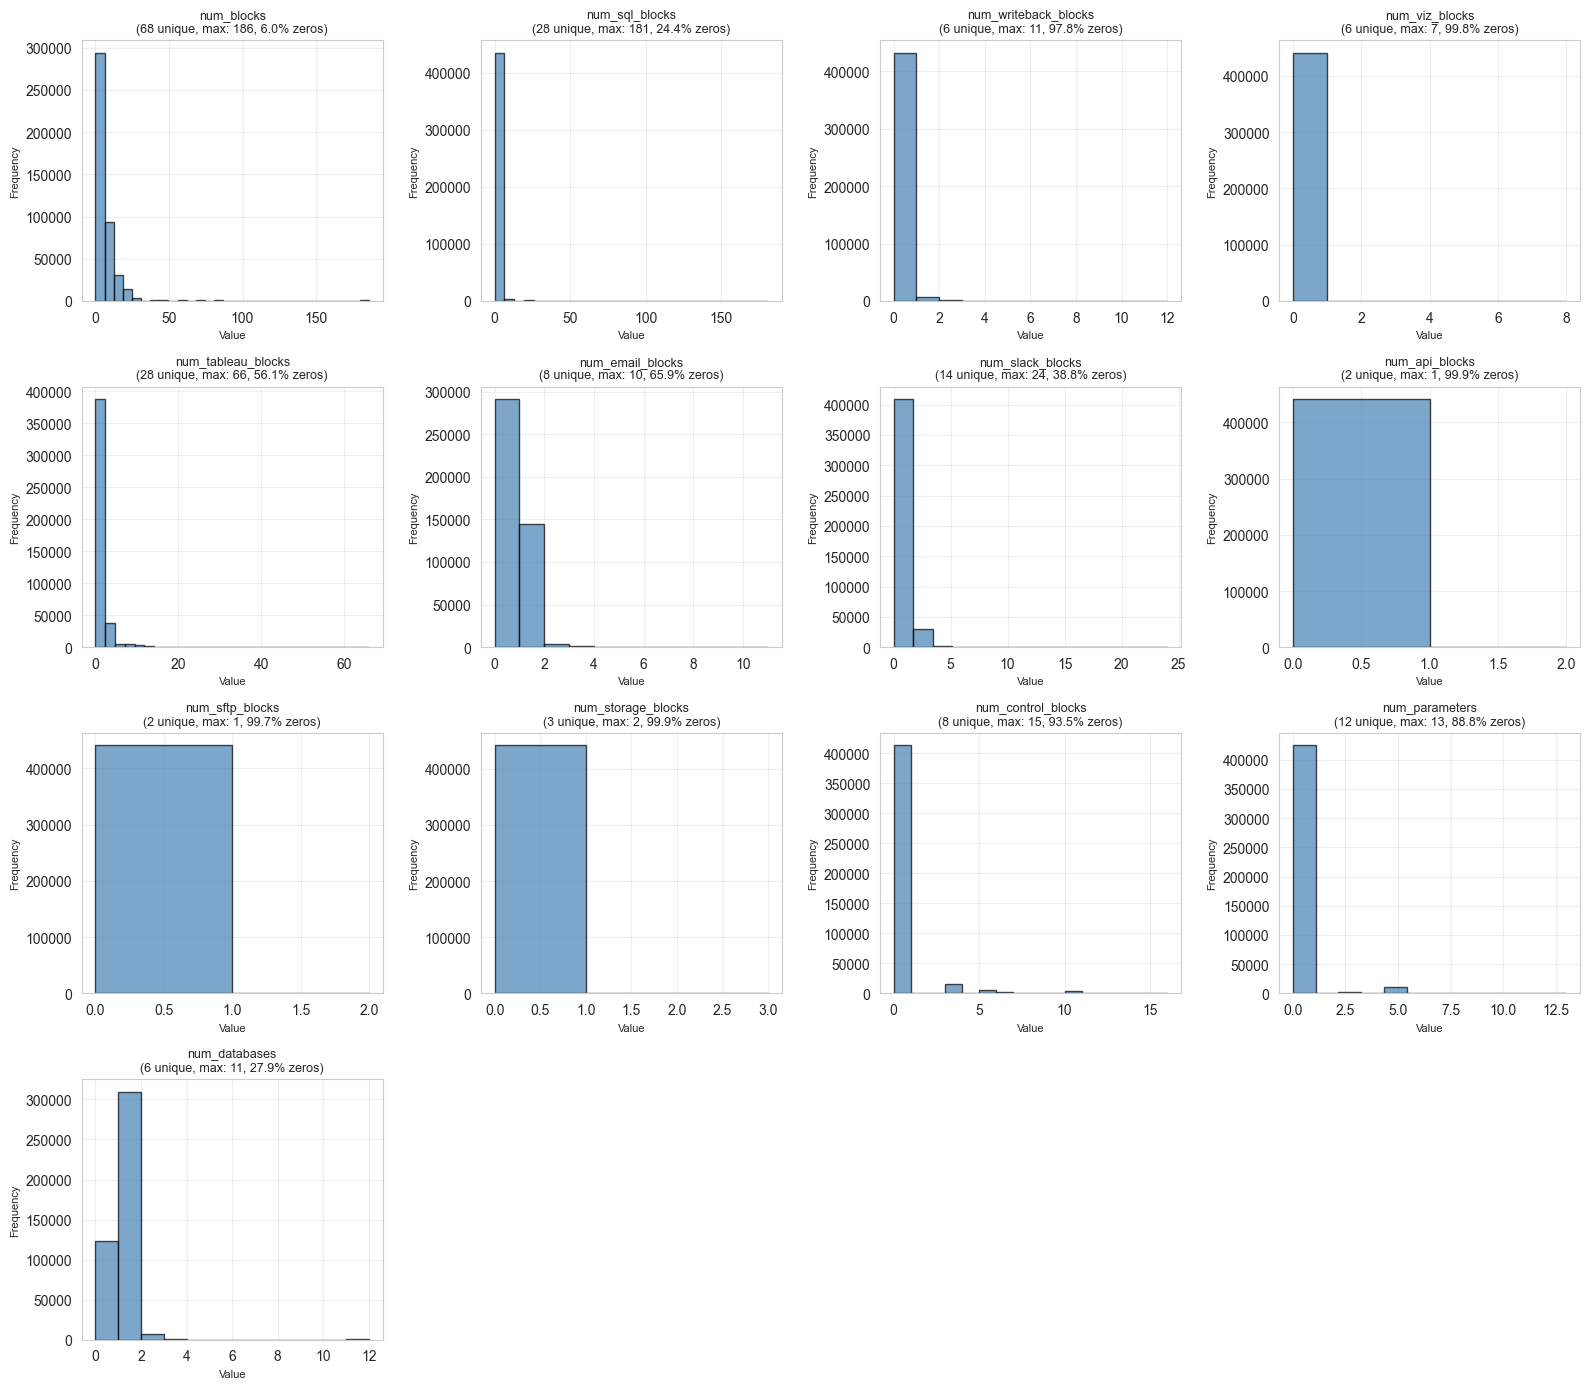


Block Features Summary:
             Feature  Unique  Max  Zeros  Non-zeros Zero %
          num_blocks      68  186  26692     415118   6.0%
      num_sql_blocks      28  181 107758     334052  24.4%
num_writeback_blocks       6   11 431927       9883  97.8%
      num_viz_blocks       6    7 441035        775  99.8%
  num_tableau_blocks      28   66 247762     194048  56.1%
    num_email_blocks       8   10 291088     150722  65.9%
    num_slack_blocks      14   24 171218     270592  38.8%
      num_api_blocks       2    1 441477        333  99.9%
     num_sftp_blocks       2    1 440654       1156  99.7%
  num_storage_blocks       3    2 441196        614  99.9%
  num_control_blocks       8   15 413002      28808  93.5%
      num_parameters      12   13 392151      49659  88.8%
       num_databases       6   11 123362     318448  27.9%


In [121]:
# Plot distribution of block count features with adaptive binning
block_features = [col for col in numerical_features if 'num_' in col]

fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.ravel()

for idx, col in enumerate(block_features):
  if idx < len(axes):
      data = df[col].dropna()
      n_unique = data.nunique()
      max_val = int(data.max())
      zero_pct = (data == 0).sum() / len(data) * 100

      # Adaptive binning based on unique values
      if n_unique <= 10:
          # For discrete features with few values, use integer bins
          bins = range(0, max_val + 2)  # 0, 1, 2, ..., max+1
      elif n_unique <= 50:
          bins = min(n_unique, 30)
      else:
          bins = 30

      axes[idx].hist(data, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
      axes[idx].set_title(f'{col}\n({n_unique} unique, max: {max_val}, {zero_pct:.1f}% zeros)', fontsize=9)
      axes[idx].set_xlabel('Value', fontsize=8)
      axes[idx].set_ylabel('Frequency', fontsize=8)
      axes[idx].grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(block_features), len(axes)):
  axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Observation: Most block features are highly skewed with majority zeros
# This indicates most reports use basic functionality (SQL/Tableau + email/slack delivery)
# Advanced features like API blocks, SFTP, storage are rare

# Summary table of block feature distributions
print("\nBlock Features Summary:")
print("="*80)

summary = []
for col in block_features:
  data = df[col].dropna()
  zero_count = (data == 0).sum()
  non_zero_count = (data > 0).sum()
  summary.append({
      'Feature': col,
      'Unique': data.nunique(),
      'Max': int(data.max()),
      'Zeros': zero_count,
      'Non-zeros': non_zero_count,
      'Zero %': f"{zero_count / len(data) * 100:.1f}%"
  })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

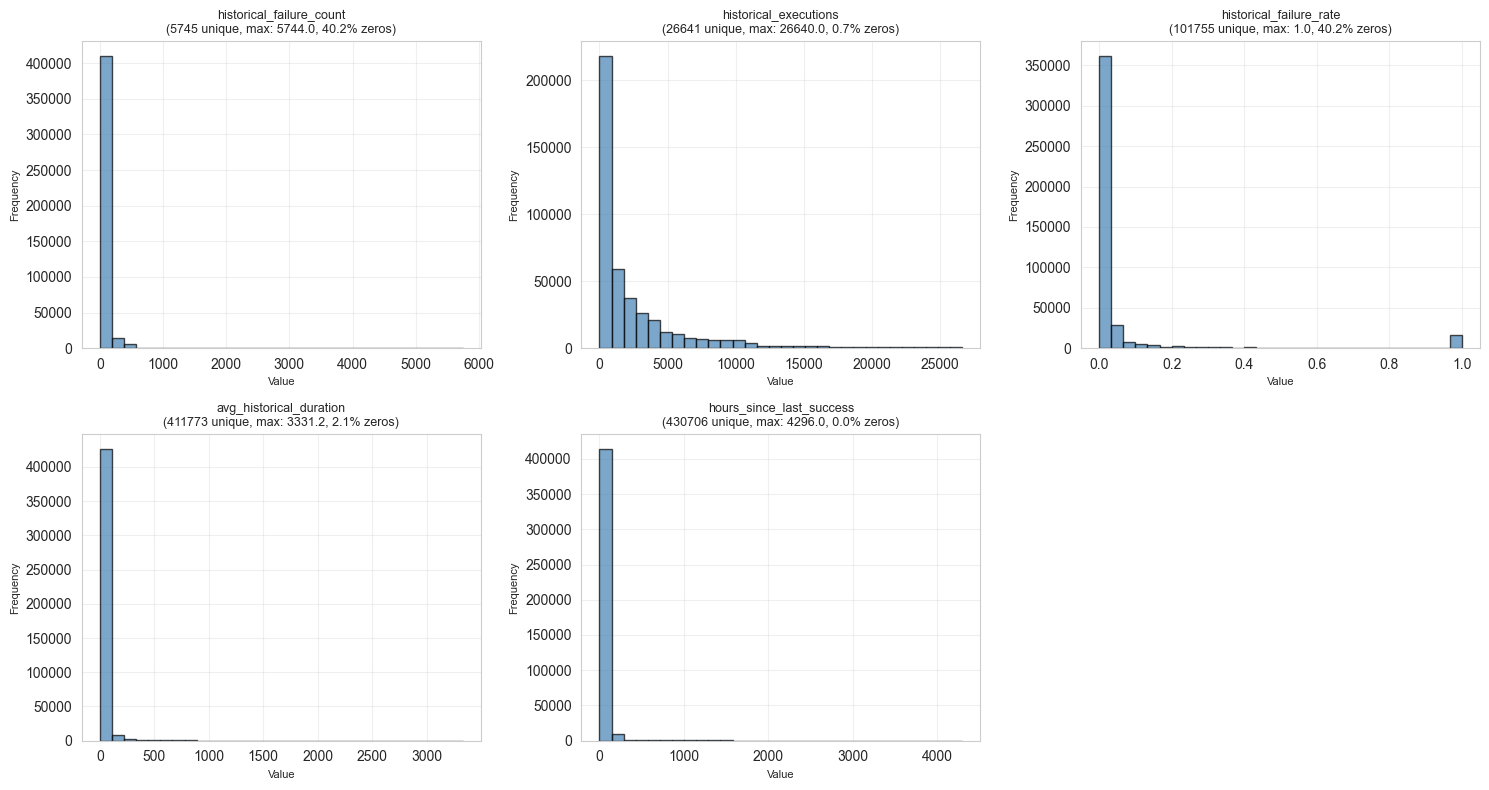


Historical Features Summary:
                 Feature  Unique      Max    Mean Median  Zeros  Non-zeros Zero %
historical_failure_count    5745  5744.00   84.99   2.00 177674     264136  40.2%
   historical_executions   26641 26640.00 2650.12 926.00   3072     438738   0.7%
 historical_failure_rate  101755     1.00    0.06   0.00 177674     264136  40.2%
 avg_historical_duration  411773  3331.18   28.00   6.85   9092     432718   2.1%
hours_since_last_success  430706  4296.01   28.53   1.00      0     430934   0.0%


In [122]:
# Historical features distribution with adaptive binning
historical_features = ['historical_failure_count', 'historical_executions',
                     'historical_failure_rate', 'avg_historical_duration',
                     'hours_since_last_success']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, col in enumerate(historical_features):
  if idx < len(axes):
      data = df[col].dropna()
      n_unique = data.nunique()
      max_val = data.max()
      zero_pct = (data == 0).sum() / len(data) * 100

      # Adaptive binning
      if n_unique <= 50:
          bins = min(n_unique, 30)
      else:
          bins = 30

      axes[idx].hist(data, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
      axes[idx].set_title(f'{col}\n({n_unique} unique, max: {max_val:.1f}, {zero_pct:.1f}% zeros)', fontsize=9)
      axes[idx].set_xlabel('Value', fontsize=8)
      axes[idx].set_ylabel('Frequency', fontsize=8)
      axes[idx].grid(True, alpha=0.3)

# Hide last unused subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Observation: Historical features show varying distributions
# - historical_failure_rate and hours_since_last_success are highly skewed (mostly zeros)
# - historical_executions shows reports with different maturity levels
# - avg_historical_duration indicates typical execution times

# Summary table of historical feature distributions
print("\nHistorical Features Summary:")
print("="*80)

summary = []
for col in historical_features:
  data = df[col].dropna()
  zero_count = (data == 0).sum()
  non_zero_count = (data > 0).sum()
  summary.append({
      'Feature': col,
      'Unique': data.nunique(),
      'Max': f"{data.max():.2f}",
      'Mean': f"{data.mean():.2f}",
      'Median': f"{data.median():.2f}",
      'Zeros': zero_count,
      'Non-zeros': non_zero_count,
      'Zero %': f"{zero_count / len(data) * 100:.1f}%"
  })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

## 5. Correlation Analysis

Correlation with target variable (failed):
failed                      1.000000
historical_failure_rate     0.820963
historical_failure_count    0.566748
hours_since_last_success    0.414464
is_rerun                    0.315911
num_sftp_blocks             0.106773
num_tableau_blocks          0.063149
avg_historical_duration     0.041085
num_api_blocks              0.039736
num_slack_blocks            0.028405
num_storage_blocks          0.021456
num_viz_blocks              0.020236
num_writeback_blocks        0.013832
num_blocks                  0.013733
num_sql_blocks              0.013619
num_parameters              0.000545
hour_of_day                -0.003935
day_of_week                -0.012545
is_business_hours          -0.013014
is_weekend                 -0.025547
num_control_blocks         -0.027269
num_email_blocks           -0.038203
historical_executions      -0.077283
num_databases              -0.129475
is_scheduled               -0.230191
Name: failed, dtype: float64


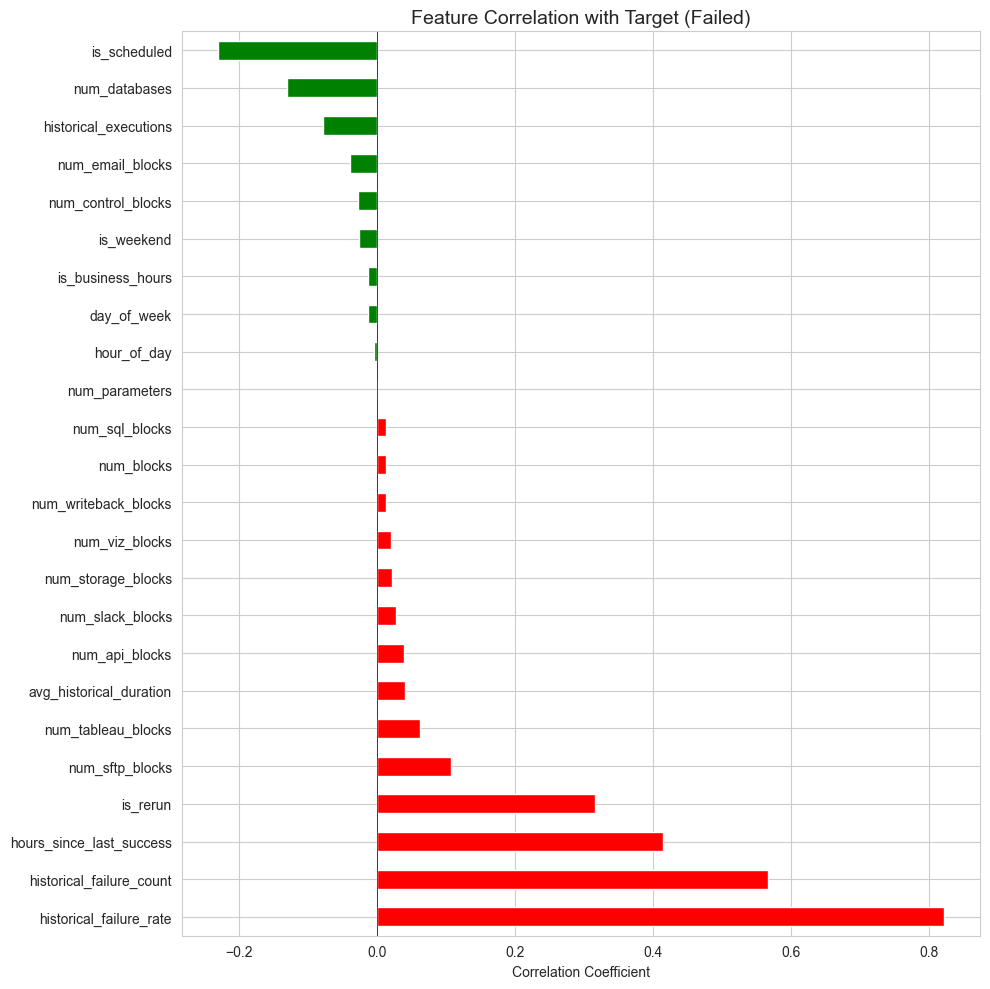

In [123]:
# Correlation with target variable
correlations = df[numerical_features + ['failed']].corr()['failed'].sort_values(ascending=False)
print("Correlation with target variable (failed):")
print(correlations)

# Plot
plt.figure(figsize=(10, 10))
correlations.drop('failed').plot(kind='barh', color=['green' if x < 0 else 'red' for x in correlations.drop('failed')])
plt.title('Feature Correlation with Target (Failed)', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

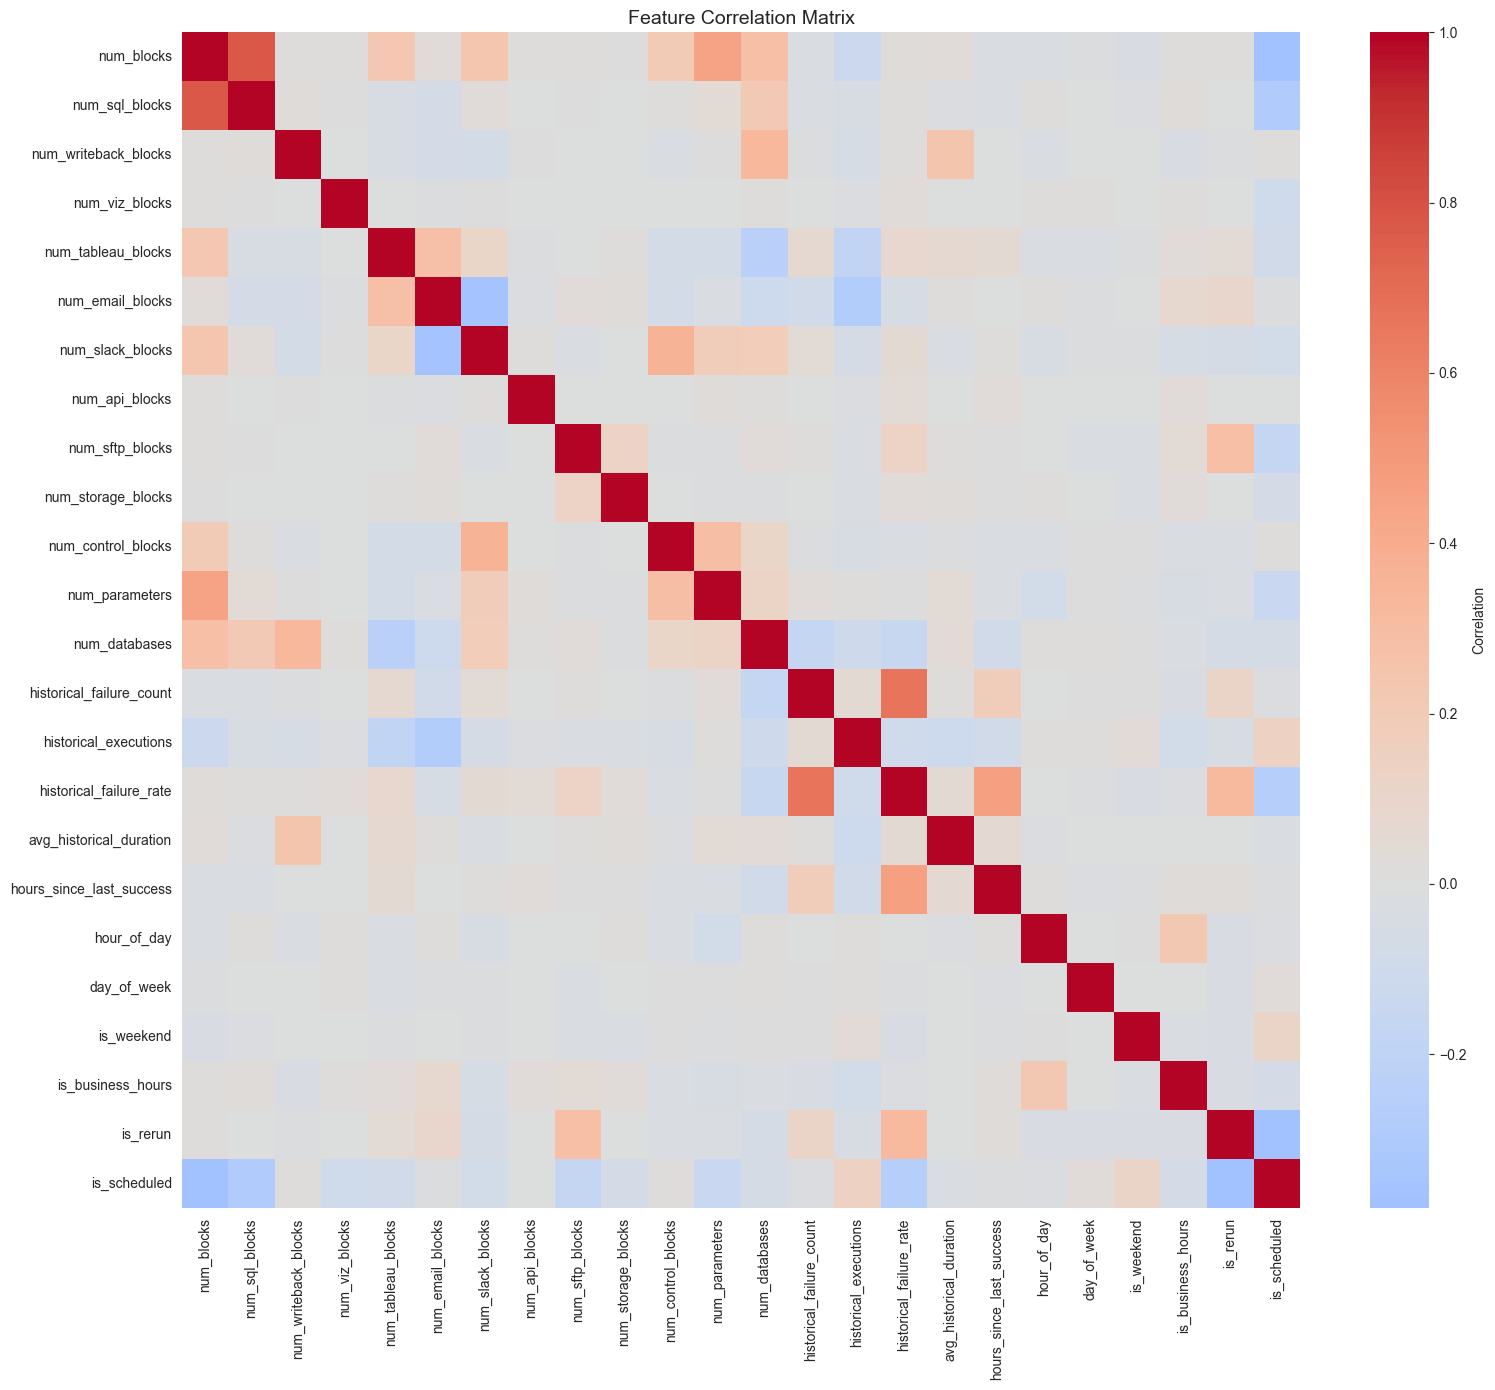

In [124]:
# Feature correlation matrix
plt.figure(figsize=(16, 14))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Categorical Features Analysis

Top 30 database type combinations:
bigquery              170052
none                  123555
postgresql             49442
mssql                  44213
snowflake              26121
awsathena              11623
mysql                   6790
vertica                 4043
clickhouse              2224
redshift                1851
gsheets                 1301
gsheets,mssql            205
mongobi,postgresql       201
bigquery,snowflake       187
gsheets,postgresql         2
Name: database_types, dtype: int64


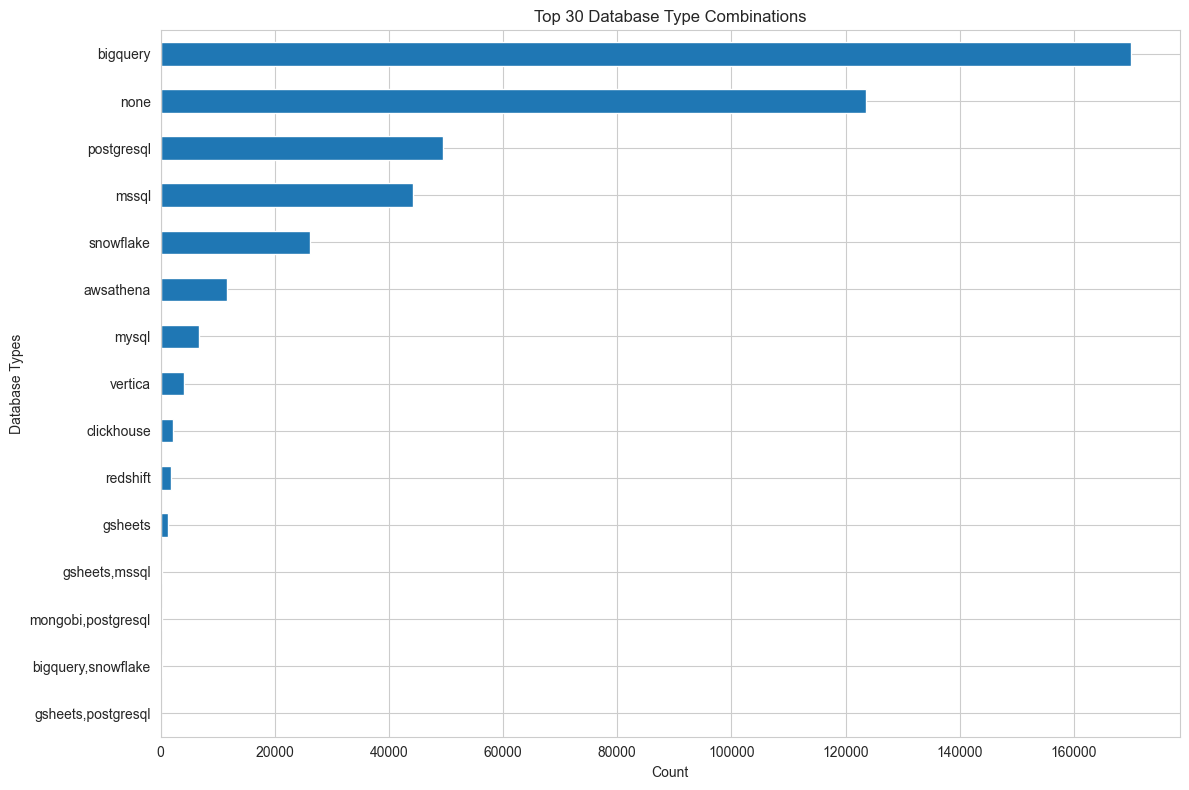

In [125]:
# Database types analysis
print("Top 30 database type combinations:")
db_types = df['database_types'].value_counts().head(30)
print(db_types)

# Visualize
plt.figure(figsize=(12, 8))
db_types.plot(kind='barh')
plt.title('Top 30 Database Type Combinations')
plt.xlabel('Count')
plt.ylabel('Database Types')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

bigquery              170052
none                  123555
postgresql             49442
mssql                  44213
snowflake              26121
awsathena              11623
mysql                   6790
vertica                 4043
clickhouse              2224
redshift                1851
gsheets                 1301
gsheets,mssql            205
mongobi,postgresql       201
bigquery,snowflake       187
gsheets,postgresql         2
Name: database_types, dtype: int64
Failure rate by database type (top 20):
                        mean   count  failure_rate
database_types                                    
gsheets,postgresql  1.000000       2    100.000000
gsheets             0.192160    1301     19.215988
clickhouse          0.156475    2224     15.647482
bigquery,snowflake  0.139037     187     13.903743
none                0.131197  123555     13.119663
redshift            0.127499    1851     12.749865
snowflake           0.092416   26121      9.241606
mongobi,postgresql  0.074627   

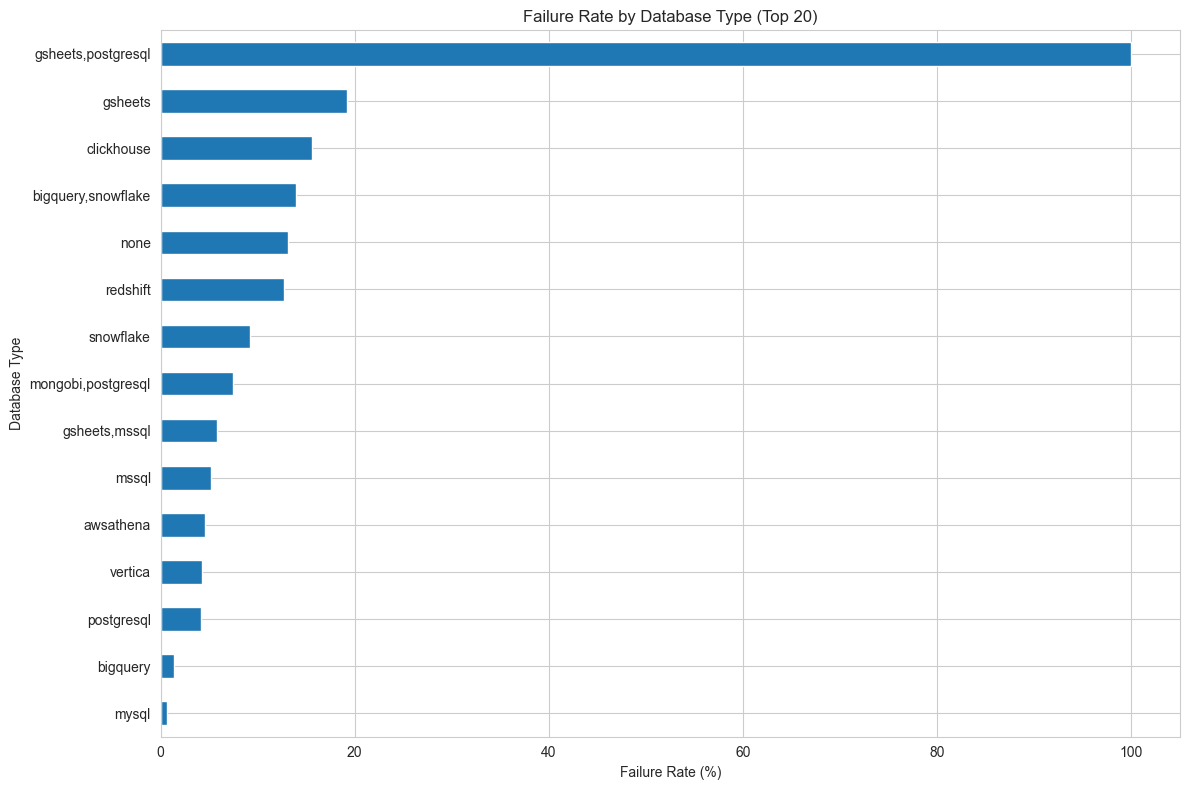

In [126]:
# Failure rate by database type (top 20)
top_db_types = df['database_types'].value_counts().head(20).index
print(df['database_types'].value_counts())
failure_by_db = df[df['database_types'].isin(top_db_types)].groupby('database_types')['failed'].agg(['mean', 'count'])
failure_by_db['failure_rate'] = failure_by_db['mean'] * 100
failure_by_db = failure_by_db.sort_values('failure_rate', ascending=False)

print("Failure rate by database type (top 20):")
print(failure_by_db)

# Visualize
plt.figure(figsize=(12, 8))
failure_by_db['failure_rate'].plot(kind='barh')
plt.title('Failure Rate by Database Type (Top 20)')
plt.xlabel('Failure Rate (%)')
plt.ylabel('Database Type')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 7. Time-based Analysis

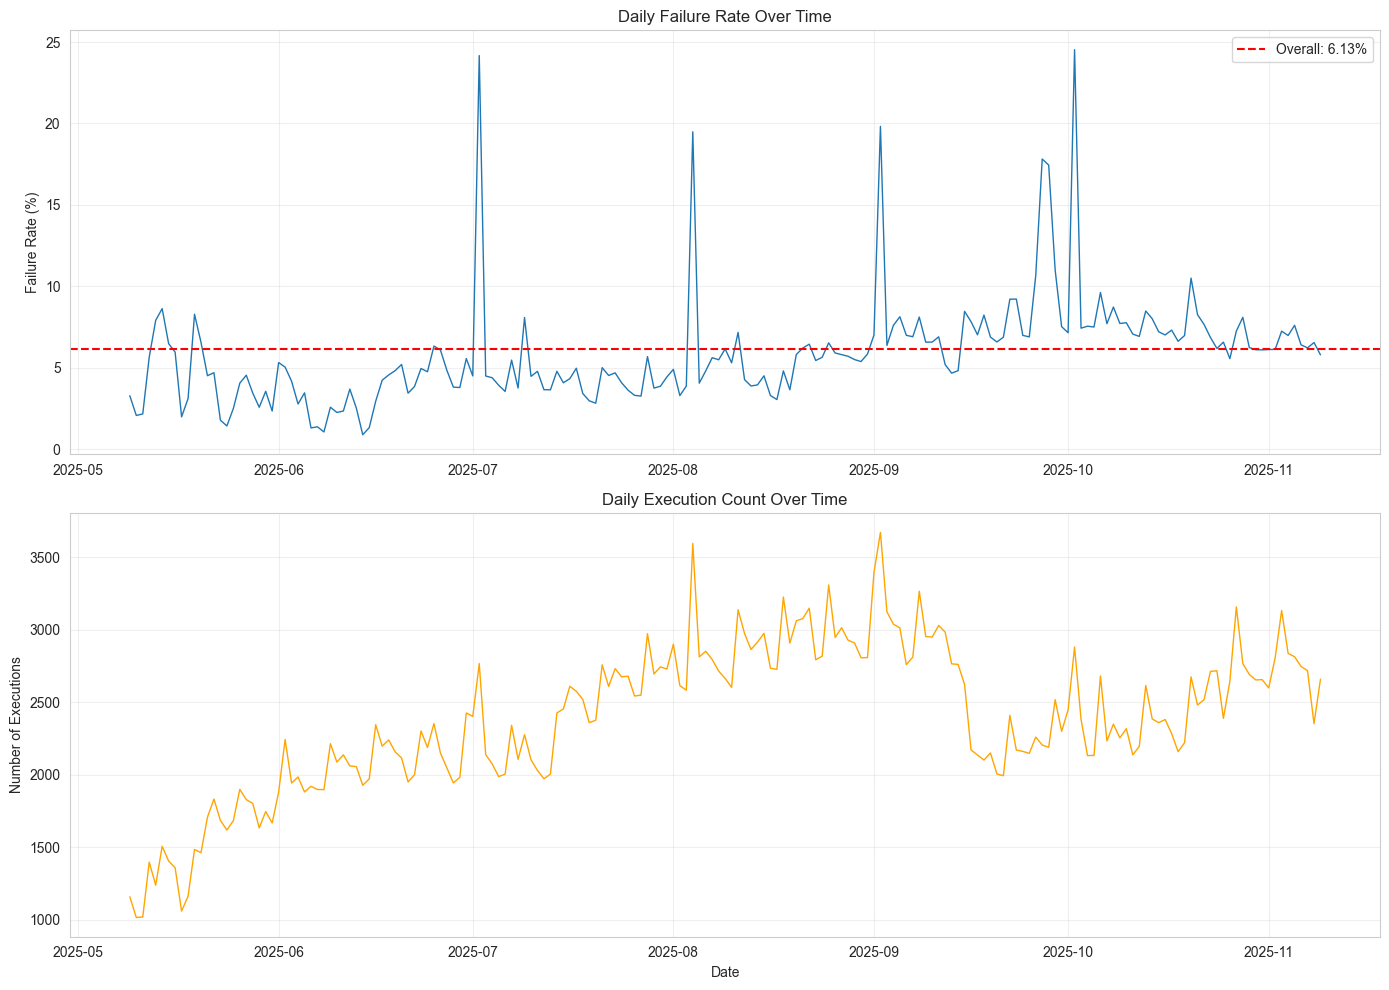

Data date range: 2025-05-09 00:00:00 to 2025-11-09 00:00:00


In [127]:
# Convert execution_date to datetime
df['execution_date'] = pd.to_datetime(df['execution_date'])

# Failure rate over time
failure_over_time = df.groupby('execution_date')['failed'].agg(['mean', 'count'])

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Failure rate
axes[0].plot(failure_over_time.index, failure_over_time['mean'] * 100, linewidth=1)
axes[0].set_title('Daily Failure Rate Over Time', fontsize=12)
axes[0].set_ylabel('Failure Rate (%)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=failure_rate, color='red', linestyle='--', label=f'Overall: {failure_rate:.2f}%')
axes[0].legend()

# Execution count
axes[1].plot(failure_over_time.index, failure_over_time['count'], linewidth=1, color='orange')
axes[1].set_title('Daily Execution Count Over Time', fontsize=12)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Executions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Data date range: {df['execution_date'].min()} to {df['execution_date'].max()}")

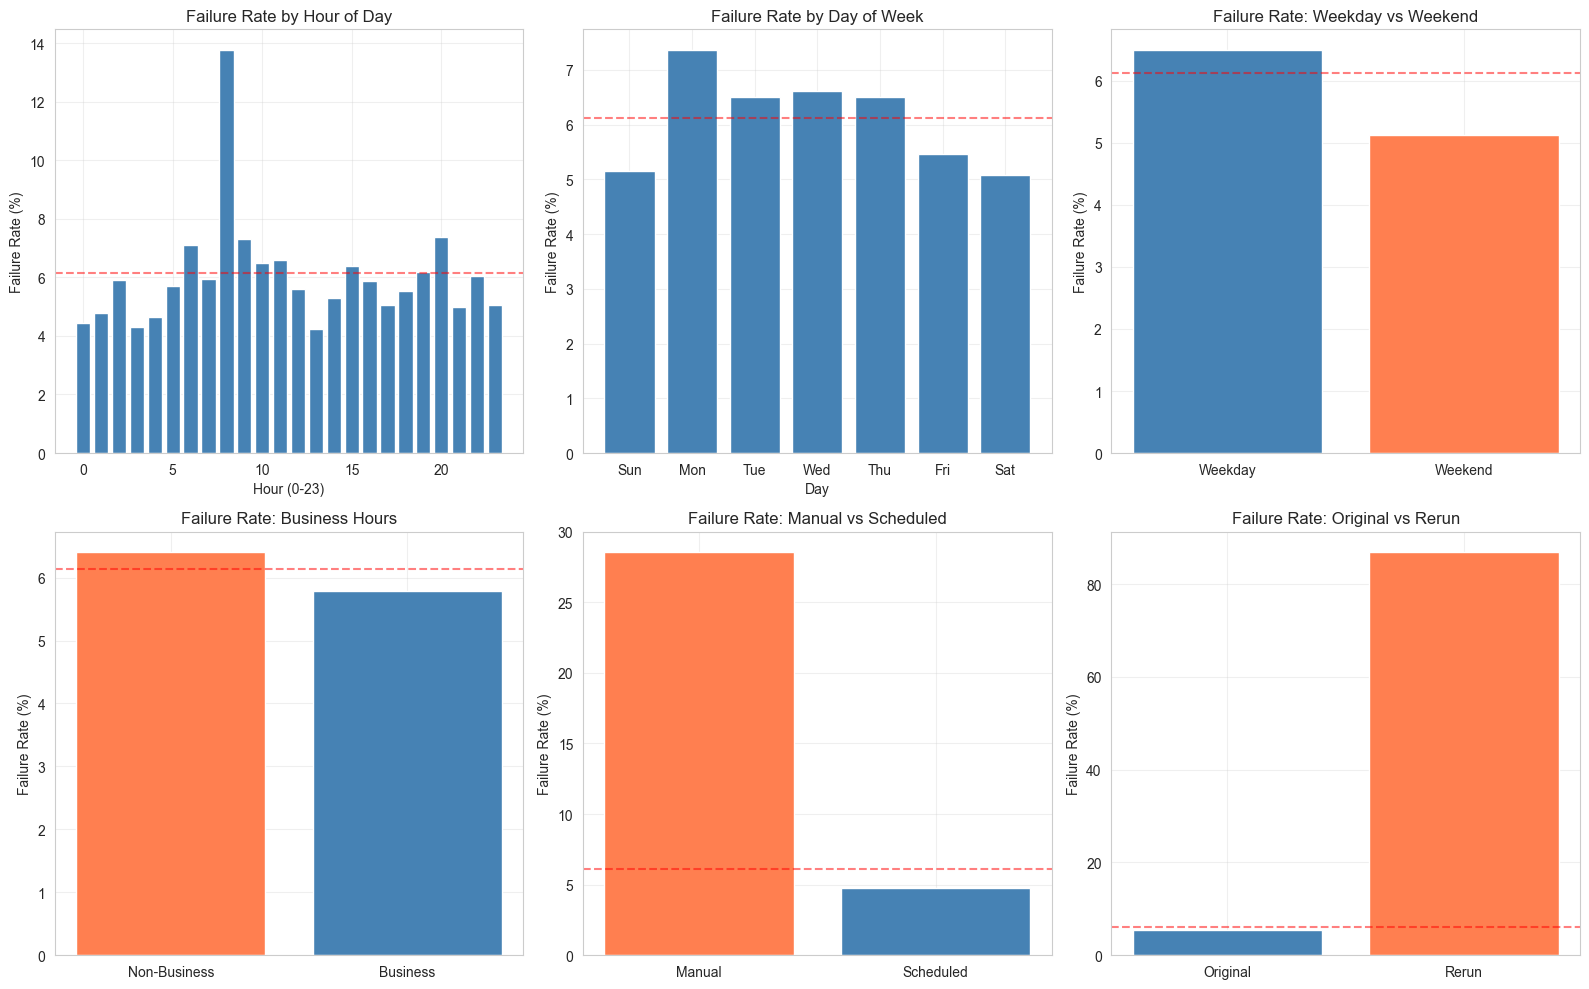

In [128]:
# Failure rate by time features
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Hour of day
failure_by_hour = df.groupby('hour_of_day')['failed'].mean() * 100
axes[0, 0].bar(failure_by_hour.index, failure_by_hour.values, color='steelblue')
axes[0, 0].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Failure Rate by Hour of Day')
axes[0, 0].set_xlabel('Hour (0-23)')
axes[0, 0].set_ylabel('Failure Rate (%)')
axes[0, 0].grid(True, alpha=0.3)

# Day of week
failure_by_dow = df.groupby('day_of_week')['failed'].mean() * 100
dow_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
axes[0, 1].bar(failure_by_dow.index, failure_by_dow.values, color='steelblue')
axes[0, 1].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Failure Rate by Day of Week')
axes[0, 1].set_xlabel('Day')
axes[0, 1].set_ylabel('Failure Rate (%)')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(dow_labels)
axes[0, 1].grid(True, alpha=0.3)

# Weekend vs Weekday
failure_by_weekend = df.groupby('is_weekend')['failed'].mean() * 100
axes[0, 2].bar(['Weekday', 'Weekend'], failure_by_weekend.values, color=['steelblue', 'coral'])
axes[0, 2].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[0, 2].set_title('Failure Rate: Weekday vs Weekend')
axes[0, 2].set_ylabel('Failure Rate (%)')
axes[0, 2].grid(True, alpha=0.3)

# Business hours
failure_by_bh = df.groupby('is_business_hours')['failed'].mean() * 100
axes[1, 0].bar(['Non-Business', 'Business'], failure_by_bh.values, color=['coral', 'steelblue'])
axes[1, 0].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Failure Rate: Business Hours')
axes[1, 0].set_ylabel('Failure Rate (%)')
axes[1, 0].grid(True, alpha=0.3)

# Scheduled vs Manual
failure_by_scheduled = df.groupby('is_scheduled')['failed'].mean() * 100
axes[1, 1].bar(['Manual', 'Scheduled'], failure_by_scheduled.values, color=['coral', 'steelblue'])
axes[1, 1].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Failure Rate: Manual vs Scheduled')
axes[1, 1].set_ylabel('Failure Rate (%)')
axes[1, 1].grid(True, alpha=0.3)

# Rerun vs Original
failure_by_rerun = df.groupby('is_rerun')['failed'].mean() * 100
axes[1, 2].bar(['Original', 'Rerun'], failure_by_rerun.values, color=['steelblue', 'coral'])
axes[1, 2].axhline(y=failure_rate, color='red', linestyle='--', alpha=0.5)
axes[1, 2].set_title('Failure Rate: Original vs Rerun')
axes[1, 2].set_ylabel('Failure Rate (%)')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Data Preparation for Modeling

- Train/validation/test split (60%/20%/20%) with random sampling
- Use DictVectorizer for feature encoding
- Handle missing values

In [129]:
target_variable = 'failed'

def split_data(df):
    full_train, test = train_test_split(df, test_size=0.2, random_state=1)
    train, val = train_test_split(full_train, test_size=0.25, random_state=1)

    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    test = test.reset_index(drop=True)

    y_var_train = train[target_variable].values
    y_var_val = val[target_variable].values
    y_var_test = test[target_variable].values

    del train[target_variable]
    del val[target_variable]
    del test[target_variable]

    full_train = full_train.reset_index(drop=True)

    return (train, y_var_train), (val, y_var_val), (test, y_var_test), full_train

# Sort by date to ensure chronological split
df_sorted = df.sort_values('execution_date').reset_index(drop=True)

n = len(df_sorted)

(df_train, y_train), (df_val, y_val), (df_test, y_test), df_full_train = split_data(df_sorted)

print(f"Training set: {len(df_train):,} rows ({len(df_train)/n*100:.1f}%)")
print(f"  Date range: {df_train['execution_date'].min()} to {df_train['execution_date'].max()}")

print(f"\nValidation set: {len(df_val):,} rows ({len(df_val)/n*100:.1f}%)")
print(f"  Date range: {df_val['execution_date'].min()} to {df_val['execution_date'].max()}")

print(f"\nTest set: {len(df_test):,} rows ({len(df_test)/n*100:.1f}%)")
print(f"  Date range: {df_test['execution_date'].min()} to {df_test['execution_date'].max()}")

Training set: 265,086 rows (60.0%)
  Date range: 2025-05-09 00:00:00 to 2025-11-09 00:00:00

Validation set: 88,362 rows (20.0%)
  Date range: 2025-05-09 00:00:00 to 2025-11-09 00:00:00

Test set: 88,362 rows (20.0%)
  Date range: 2025-05-09 00:00:00 to 2025-11-09 00:00:00


In [130]:
# Prepare features function
def prepare_features(df_input):
    """
    Convert dataframe to list of dictionaries for DictVectorizer.
    Fill missing values and select only feature columns.
    """
    df_features = df_input[feature_cols].copy()
    
    # Fill NaN values with 0
    df_features = df_features.fillna(0)
    
    # Convert numerical columns to appropriate types
    for col in numerical_features:
        if col in df_features.columns:
            df_features[col] = df_features[col].astype(float)
    
    # Convert categorical columns to string
    for col in categorical_features:
        if col in df_features.columns:
            df_features[col] = df_features[col].astype(str)
    
    # Convert to list of dicts (required for DictVectorizer)
    return df_features.to_dict(orient='records')

# Prepare features and targets
X_train_dicts = prepare_features(df_train)

X_val_dicts = prepare_features(df_val)

X_test_dicts = prepare_features(df_test)

print(f"Prepared {len(X_train_dicts):,} training samples")
print(f"Prepared {len(X_val_dicts):,} validation samples")
print(f"Prepared {len(X_test_dicts):,} test samples")

print(f"\nExample feature dict:")
print(X_train_dicts[0])

Prepared 265,086 training samples
Prepared 88,362 validation samples
Prepared 88,362 test samples

Example feature dict:
{'num_blocks': 7.0, 'num_sql_blocks': 1.0, 'num_writeback_blocks': 0.0, 'num_viz_blocks': 0.0, 'num_tableau_blocks': 2.0, 'num_email_blocks': 0.0, 'num_slack_blocks': 1.0, 'num_api_blocks': 0.0, 'num_sftp_blocks': 0.0, 'num_storage_blocks': 0.0, 'num_control_blocks': 0.0, 'num_parameters': 0.0, 'num_databases': 1.0, 'historical_failure_count': 2.0, 'historical_executions': 1170.0, 'historical_failure_rate': 0.0017094017094017, 'avg_historical_duration': 7.093105394691781, 'hours_since_last_success': 0.9976956255555556, 'hour_of_day': 14.0, 'day_of_week': 2.0, 'is_weekend': 0.0, 'is_business_hours': 1.0, 'is_rerun': 0.0, 'is_scheduled': 1.0, 'database_types': 'bigquery'}


In [131]:
# Apply DictVectorizer for one-hot encoding
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train_dicts)
X_val = dv.transform(X_val_dicts)
X_test = dv.transform(X_test_dicts)

print(f"Feature matrix shapes:")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")
print(f"\nTotal features after one-hot encoding: {len(dv.get_feature_names_out())}")
print(f"\nAll feature names:")
print(list(dv.get_feature_names_out()[:40]))

Feature matrix shapes:
  Training: (265086, 39)
  Validation: (88362, 39)
  Test: (88362, 39)

Total features after one-hot encoding: 39

All feature names:
['avg_historical_duration', 'database_types=awsathena', 'database_types=bigquery', 'database_types=bigquery,snowflake', 'database_types=clickhouse', 'database_types=gsheets', 'database_types=gsheets,mssql', 'database_types=gsheets,postgresql', 'database_types=mongobi,postgresql', 'database_types=mssql', 'database_types=mysql', 'database_types=none', 'database_types=postgresql', 'database_types=redshift', 'database_types=snowflake', 'database_types=vertica', 'day_of_week', 'historical_executions', 'historical_failure_count', 'historical_failure_rate', 'hour_of_day', 'hours_since_last_success', 'is_business_hours', 'is_rerun', 'is_scheduled', 'is_weekend', 'num_api_blocks', 'num_blocks', 'num_control_blocks', 'num_databases', 'num_email_blocks', 'num_parameters', 'num_sftp_blocks', 'num_slack_blocks', 'num_sql_blocks', 'num_storage_b

## 9. Model Training - Logistic Regression

Starting with a simple baseline model.

In [132]:
# Train Logistic Regression with K-Fold Cross-Validation
print("Training Logistic Regression with K-Fold Cross Validation")
print("="*60)

# Extract y from df_full_train (it still has the 'failed' column!)
y_full_train = df_full_train[target_variable].values

print(f"Full training set size: {len(df_full_train):,} rows")
print(f"Features available: {[col for col in df_full_train.columns if col != target_variable][:5]}...")

# Define train function (vectorizes inside)
def train_lr(df_fold_train, y_fold_train, C=1.0):
  """Train logistic regression on a fold"""
  # Prepare features (exclude target and other columns)
  train_dicts = prepare_features(df_fold_train)

  # Vectorize
  dv_fold = DictVectorizer(sparse=False)
  X_fold_train = dv_fold.fit_transform(train_dicts)

  # Train model
  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=1)
  model.fit(X_fold_train, y_fold_train)

  return dv_fold, model

# Define predict function
def predict_lr(df_fold_val, dv_fold, model):
  """Make predictions on a fold"""
  val_dicts = prepare_features(df_fold_val)
  X_fold_val = dv_fold.transform(val_dicts)
  y_pred = model.predict_proba(X_fold_val)[:, 1]
  return y_pred

# parameters to test
C_values = [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
n_splits = 5

# Test different C values with K-Fold CV
best_C = None
best_mean_auc = 0

for C in tqdm(C_values, desc="Testing C values"):
  scores = []

  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

  for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits, desc=f"C={C}", leave=False):
      # Split using iloc
      df_fold_train = df_full_train.iloc[train_idx]
      df_fold_val = df_full_train.iloc[val_idx]

      y_fold_train = y_full_train[train_idx]
      y_fold_val = y_full_train[val_idx]

      # Train and predict
      dv_fold, model = train_lr(df_fold_train, y_fold_train, C=C)
      y_pred = predict_lr(df_fold_val, dv_fold, model)

      # Evaluate
      auc = roc_auc_score(y_fold_val, y_pred)
      scores.append(auc)

  mean_auc = np.mean(scores)
  std_auc = np.std(scores)

  print(f'C={C:>6} | AUC: {mean_auc:.3f} +- {std_auc:.3f}')

  # Track best C
  if mean_auc > best_mean_auc:
      best_mean_auc = mean_auc
      best_C = C

print("\n" + "="*60)
print(f"Best C: {best_C} with Mean AUC: {best_mean_auc:.4f}")
print("="*60)

# Train final model with best C on original train set
print(f"\nTraining final Logistic Regression model with C={best_C}...")
lr_model = LogisticRegression(solver='liblinear', C=best_C, max_iter=1000, random_state=1)
lr_model.fit(X_train, y_train)

# Predictions (probabilities)
y_train_pred_lr = lr_model.predict_proba(X_train)[:, 1]
y_val_pred_lr = lr_model.predict_proba(X_val)[:, 1]

# Evaluate
train_auc_lr = roc_auc_score(y_train, y_train_pred_lr)
val_auc_lr = roc_auc_score(y_val, y_val_pred_lr)

print(f"\nLogistic Regression Results (C={best_C}):")
print(f"  Training AUC:   {train_auc_lr:.4f}")
print(f"  Validation AUC: {val_auc_lr:.4f}")
print(f"  Difference:     {abs(train_auc_lr - val_auc_lr):.4f}")

Training Logistic Regression with K-Fold Cross Validation
Full training set size: 353,448 rows
Features available: ['execution_id', 'report_hash', 'workspace_hash', 'num_blocks', 'num_sql_blocks']...


Testing C values:   0%|          | 0/7 [00:00<?, ?it/s]

C=0.001:   0%|          | 0/5 [00:00<?, ?it/s]

C= 0.001 | AUC: 0.954 +- 0.002


C=0.01:   0%|          | 0/5 [00:00<?, ?it/s]

C=  0.01 | AUC: 0.963 +- 0.002


C=0.1:   0%|          | 0/5 [00:00<?, ?it/s]

C=   0.1 | AUC: 0.964 +- 0.001


C=0.5:   0%|          | 0/5 [00:00<?, ?it/s]

C=   0.5 | AUC: 0.964 +- 0.002


C=1:   0%|          | 0/5 [00:00<?, ?it/s]

C=     1 | AUC: 0.964 +- 0.001


C=5:   0%|          | 0/5 [00:00<?, ?it/s]

C=     5 | AUC: 0.964 +- 0.002


C=10:   0%|          | 0/5 [00:00<?, ?it/s]

C=    10 | AUC: 0.964 +- 0.001

Best C: 5 with Mean AUC: 0.9644

Training final Logistic Regression model with C=5...

Logistic Regression Results (C=5):
  Training AUC:   0.9640
  Validation AUC: 0.9645
  Difference:     0.0005


## 10. Model Training - Random Forest

Tree-based model that can capture non-linear relationships.

Training Random Forest with Parameter Tuning...
Testing parameter combinations...
Total combinations: 120
Training: n_estimators=10, max_depth=5, min_samples_leaf=1
  Train AUC: 0.9707, Val AUC: 0.9708, Diff: 0.0001
Training: n_estimators=10, max_depth=5, min_samples_leaf=3
  Train AUC: 0.9648, Val AUC: 0.9646, Diff: 0.0002
Training: n_estimators=10, max_depth=5, min_samples_leaf=5
  Train AUC: 0.9670, Val AUC: 0.9675, Diff: 0.0005
Training: n_estimators=10, max_depth=5, min_samples_leaf=10
  Train AUC: 0.9653, Val AUC: 0.9655, Diff: 0.0002
Training: n_estimators=10, max_depth=5, min_samples_leaf=20
  Train AUC: 0.9657, Val AUC: 0.9661, Diff: 0.0005
Training: n_estimators=10, max_depth=5, min_samples_leaf=50
  Train AUC: 0.9656, Val AUC: 0.9663, Diff: 0.0007
Training: n_estimators=10, max_depth=10, min_samples_leaf=1
  Train AUC: 0.9818, Val AUC: 0.9809, Diff: 0.0010
Training: n_estimators=10, max_depth=10, min_samples_leaf=3
  Train AUC: 0.9788, Val AUC: 0.9773, Diff: 0.0014
Training:

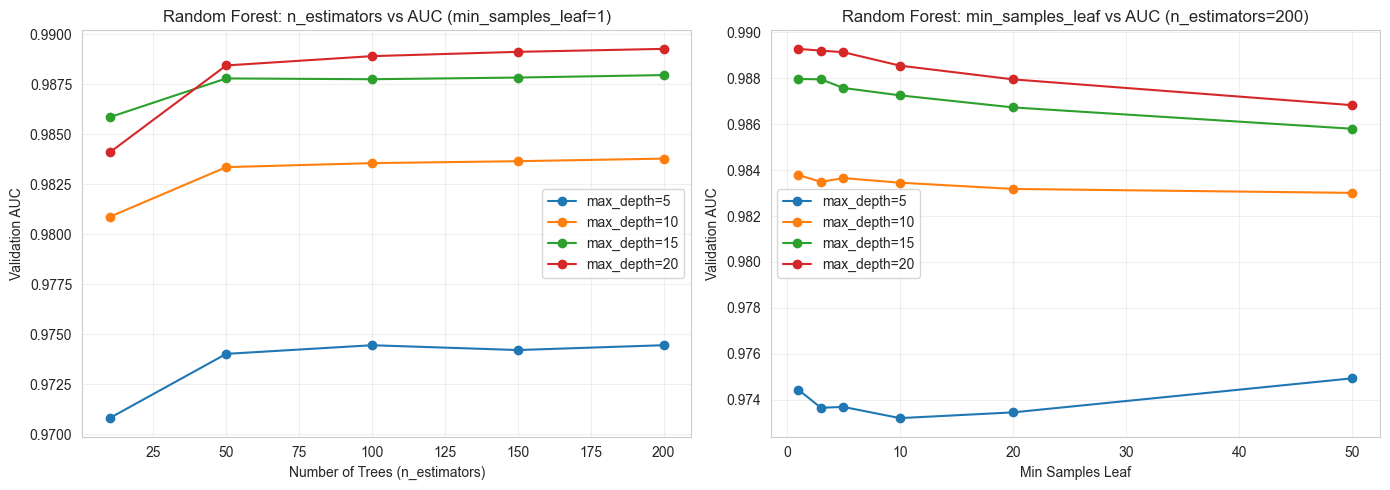


Training final Random Forest model with best parameters...

Final Random Forest Results:
  Training AUC:   0.9996
  Validation AUC: 0.9893
  Difference:     0.0103


In [133]:
# Train Random Forest with Parameter Tuning
print("Training Random Forest with Parameter Tuning...")
print("="*60)

# Test different parameter combinations
scores = []

n_estimators_values = [10, 50, 100, 150, 200]
max_depth_values = [5, 10, 15, 20]
min_samples_leaf_values = [1, 3, 5, 10, 20, 50]

print("Testing parameter combinations...")
print(f"Total combinations: {len(n_estimators_values) * len(max_depth_values) * len(min_samples_leaf_values)}")

for n in n_estimators_values:
  for d in max_depth_values:
      for s in min_samples_leaf_values:
          print(f"Training: n_estimators={n}, max_depth={d}, min_samples_leaf={s}")

          rf = RandomForestClassifier(
              n_estimators=n,
              max_depth=d,
              min_samples_leaf=s,
              random_state=1,
              n_jobs=-1
          )
          rf.fit(X_train, y_train)

          # Predictions
          y_train_pred = rf.predict_proba(X_train)[:, 1]
          y_val_pred = rf.predict_proba(X_val)[:, 1]

          # Evaluate
          train_auc = roc_auc_score(y_train, y_train_pred)
          val_auc = roc_auc_score(y_val, y_val_pred)

          scores.append({
              'n_estimators': n,
              'max_depth': d,
              'min_samples_leaf': s,
              'train_auc': train_auc,
              'val_auc': val_auc,
              'diff': abs(train_auc - val_auc)
          })

          print(f"  Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, Diff: {abs(train_auc - val_auc):.4f}")

# Convert to DataFrame
df_scores = pd.DataFrame(scores)
print("\n" + "="*60)
print("Top 10 Best Models by Validation AUC:")
print("="*60)
print(df_scores.sort_values('val_auc', ascending=False).head(10).to_string(index=False))

# Find best model
best_params = df_scores.loc[df_scores['val_auc'].idxmax()]
print("\n" + "="*60)
print("Best Random Forest Parameters:")
print("="*60)
print(f"  n_estimators:     {int(best_params['n_estimators'])}")
print(f"  max_depth:        {int(best_params['max_depth'])}")
print(f"  min_samples_leaf: {int(best_params['min_samples_leaf'])}")
print(f"  Training AUC:     {best_params['train_auc']:.4f}")
print(f"  Validation AUC:   {best_params['val_auc']:.4f}")
print(f"  Difference:       {best_params['diff']:.4f}")

# Visualize: n_estimators vs AUC for different max_depths
print("\nGenerating visualization...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: n_estimators vs val_auc for different max_depths (fixed min_samples_leaf=3)
best_min_samples = int(best_params['min_samples_leaf'])
df_subset = df_scores[df_scores['min_samples_leaf'] == best_min_samples]

for d in max_depth_values:
  df_depth = df_subset[df_subset['max_depth'] == d]
  axes[0].plot(df_depth['n_estimators'], df_depth['val_auc'],
               marker='o', label=f'max_depth={d}')

axes[0].set_xlabel('Number of Trees (n_estimators)')
axes[0].set_ylabel('Validation AUC')
axes[0].set_title(f'Random Forest: n_estimators vs AUC (min_samples_leaf={best_min_samples})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: min_samples_leaf vs val_auc for different max_depths (fixed n_estimators=100)
best_n_estimators = int(best_params['n_estimators'])
df_subset = df_scores[df_scores['n_estimators'] == best_n_estimators]

for d in max_depth_values:
  df_depth = df_subset[df_subset['max_depth'] == d]
  axes[1].plot(df_depth['min_samples_leaf'], df_depth['val_auc'],
               marker='o', label=f'max_depth={d}')

axes[1].set_xlabel('Min Samples Leaf')
axes[1].set_ylabel('Validation AUC')
axes[1].set_title(f'Random Forest: min_samples_leaf vs AUC (n_estimators={best_n_estimators})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Train final best model
print("\n" + "="*60)
print("Training final Random Forest model with best parameters...")
print("="*60)

best_rf = RandomForestClassifier(
  n_estimators=int(best_params['n_estimators']),
  max_depth=int(best_params['max_depth']),
  min_samples_leaf=int(best_params['min_samples_leaf']),
  random_state=1,
  n_jobs=-1
)
best_rf.fit(X_train, y_train)

# Final predictions
y_train_pred_rf = best_rf.predict_proba(X_train)[:, 1]
y_val_pred_rf = best_rf.predict_proba(X_val)[:, 1]

train_auc_rf = roc_auc_score(y_train, y_train_pred_rf)
val_auc_rf = roc_auc_score(y_val, y_val_pred_rf)

print(f"\nFinal Random Forest Results:")
print(f"  Training AUC:   {train_auc_rf:.4f}")
print(f"  Validation AUC: {val_auc_rf:.4f}")
print(f"  Difference:     {abs(train_auc_rf - val_auc_rf):.4f}")


Random Forest Feature Importance Analysis

Top 30 Most Important Features:
                  feature  importance
  historical_failure_rate    0.343573
 historical_failure_count    0.216577
 hours_since_last_success    0.120914
  avg_historical_duration    0.073198
    historical_executions    0.057527
                 is_rerun    0.028114
               num_blocks    0.022169
             is_scheduled    0.021055
       num_tableau_blocks    0.020722
              hour_of_day    0.017101
              day_of_week    0.011489
           num_sql_blocks    0.011127
         num_email_blocks    0.010170
         num_slack_blocks    0.008605
            num_databases    0.006350
      database_types=none    0.004624
  database_types=bigquery    0.003645
        is_business_hours    0.003408
           num_parameters    0.002913
               is_weekend    0.002562
          num_sftp_blocks    0.001990
       num_control_blocks    0.001844
 database_types=snowflake    0.001759
database_typ

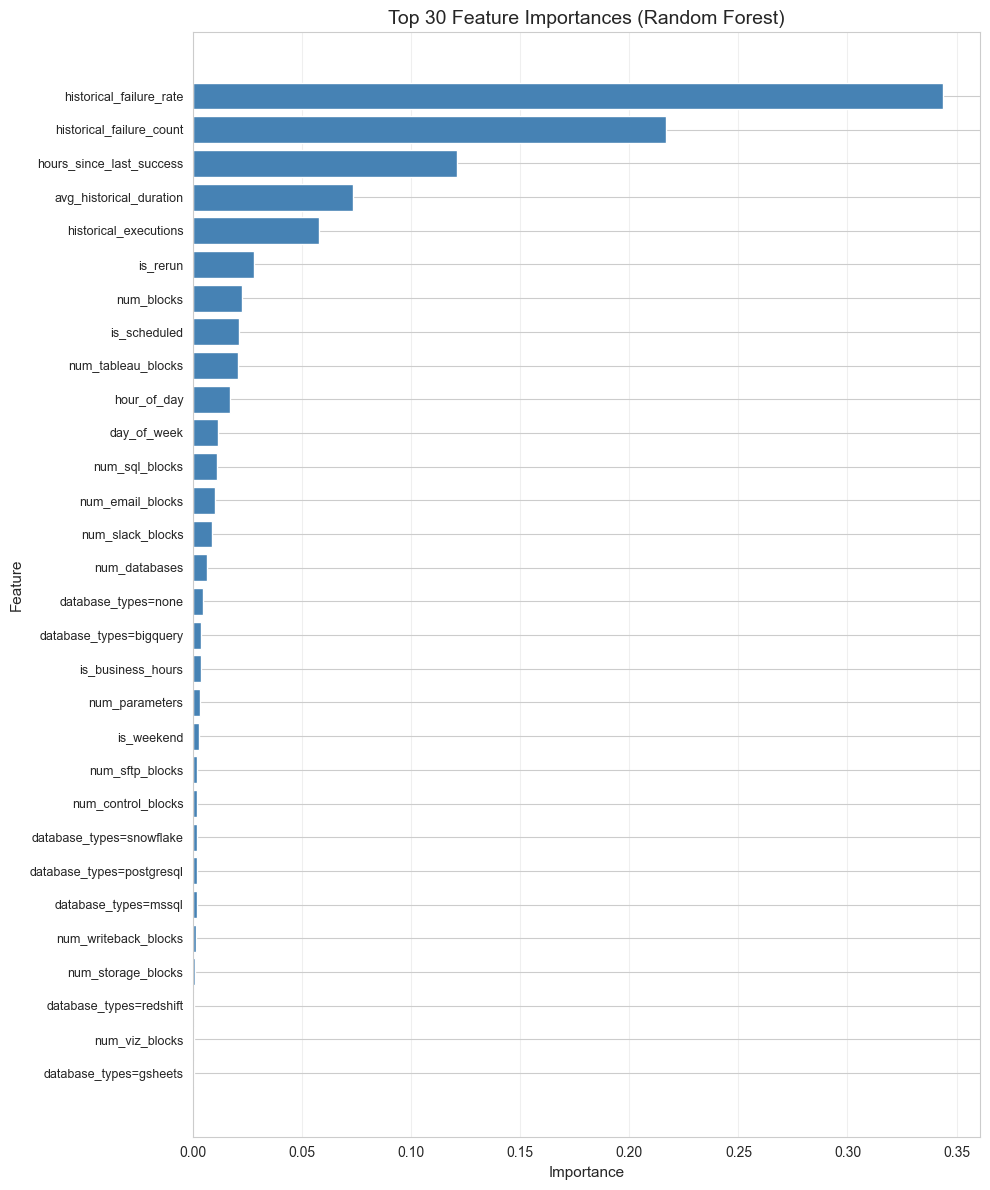


Feature Importance Statistics:
  Total features: 39
  Top feature: historical_failure_rate
  Top feature importance: 0.3436
  Top 5 cumulative importance: 0.8118
  Top 10 cumulative importance: 0.9209


In [134]:
# Feature importance from best RF model
print("\n" + "="*60)
print("Random Forest Feature Importance Analysis")
print("="*60)

feature_importance = pd.DataFrame({
  'feature': dv.get_feature_names_out(),
  'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features:")
print(feature_importance.head(30).to_string(index=False))

# Plot
plt.figure(figsize=(10, 12))
top_features = feature_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'].values, fontsize=9)
plt.xlabel('Importance', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Top 30 Feature Importances (Random Forest)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\nFeature Importance Statistics:")
print(f"  Total features: {len(feature_importance)}")
print(f"  Top feature: {feature_importance.iloc[0]['feature']}")
print(f"  Top feature importance: {feature_importance.iloc[0]['importance']:.4f}")
print(f"  Top 5 cumulative importance: {feature_importance.head(5)['importance'].sum():.4f}")
print(f"  Top 10 cumulative importance: {feature_importance.head(10)['importance'].sum():.4f}")

## 11. Model Training - XGBoost

Gradient boosting often provides the best performance.

In [135]:
# Prepare DMatrix for XGBoost (more efficient)
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.get_feature_names_out())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.get_feature_names_out())

print("DMatrix created successfully!")

DMatrix created successfully!


In [136]:
# Train XGBoost with different parameters
print("Training XGBoost models...")

# eta tunning
eta_params = [0.3, 1.0, 0.1, 0.05, 0.01]
#min_child_weight_params = [1, 10, 30]

xgb_params_list = []
for eta in eta_params:
    xgb_params = {
        'eta': eta,
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }
    xgb_params_list.append(xgb_params)

xgb_results = []
for params in xgb_params_list:
    print(f"\nTraining XGBoost with eta params:")
    print(f"  eta={params['eta']}")

    # Train with early stopping
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=watchlist,
        verbose_eval=5
    )

    # Predictions
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)

    # Evaluate
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)

    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': model.best_iteration
    })

    print(f"  Best iteration:  {model.best_iteration}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")

# Find best XGBoost model
best_xgb = max(xgb_results, key=lambda x: x['val_auc'])
print(f"\n{'=' * 50}")
print(f"Best XGBoost for eta params:")
print(f"  Params: eta={best_xgb['params']['eta']}")
print(f"  Best iteration: {best_xgb['best_iteration']}")
print(f"  Validation AUC: {best_xgb['val_auc']:.4f}")

# max_depth tunning
max_depth_params = [6, 3, 4, 10]

xgb_params_list = []
for depth in max_depth_params:
    xgb_params = {
        'eta': 0.1,
        'max_depth': depth,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }
    xgb_params_list.append(xgb_params)

xgb_results = []
for params in xgb_params_list:
    print(f"\nTraining XGBoost with max_depth params:")
    print(f"  max_depth={params['max_depth']}")

    # Train with early stopping
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=watchlist,
        verbose_eval=5
    )

    # Predictions
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)

    # Evaluate
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)

    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': model.best_iteration
    })

    print(f"  Best iteration:  {model.best_iteration}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")

# Find best XGBoost model
best_xgb = max(xgb_results, key=lambda x: x['val_auc'])
print(f"\n{'=' * 50}")
print(f"Best XGBoost for max_depth params:")
print(f"  Params: max_depth={best_xgb['params']['max_depth']}")
print(f"  Best iteration: {best_xgb['best_iteration']}")
print(f"  Validation AUC: {best_xgb['val_auc']:.4f}")

# min_child_weight tunning
min_child_weight_params = [1, 10, 30]

xgb_params_list = []
for weight in min_child_weight_params:
    xgb_params = {
        'eta': 0.1,
        'max_depth': 10,
        'min_child_weight': weight,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1
    }
    xgb_params_list.append(xgb_params)

xgb_results = []
for params in xgb_params_list:
    print(f"\nTraining XGBoost with min_child_weight params:")
    print(f"  min_child_weight={params['min_child_weight']}")

    # Train with early stopping
    watchlist = [(dtrain, 'train'), (dval, 'val')]

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=200,
        evals=watchlist,
        verbose_eval=5
    )

    # Predictions
    y_train_pred_xgb = model.predict(dtrain)
    y_val_pred_xgb = model.predict(dval)

    # Evaluate
    train_auc = roc_auc_score(y_train, y_train_pred_xgb)
    val_auc = roc_auc_score(y_val, y_val_pred_xgb)

    xgb_results.append({
        'model': model,
        'params': params,
        'train_auc': train_auc,
        'val_auc': val_auc,
        'y_val_pred': y_val_pred_xgb,
        'best_iteration': model.best_iteration
    })

    print(f"  Best iteration:  {model.best_iteration}")
    print(f"  Training AUC:    {train_auc:.4f}")
    print(f"  Validation AUC:  {val_auc:.4f}")
    print(f"  Difference:      {abs(train_auc - val_auc):.4f}")

# Find best XGBoost model
best_xgb = max(xgb_results, key=lambda x: x['val_auc'])
print(f"\n{'=' * 50}")
print(f"Best XGBoost for min_child_weight params:")
print(f"  Params: min_child_weight={best_xgb['params']['min_child_weight']}")
print(f"  Best iteration: {best_xgb['best_iteration']}")
print(f"  Validation AUC: {best_xgb['val_auc']:.4f}")

# final model with best parameters after tunning

final_xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1
}

print(f"\nTraining XGBoost with params:")
print(f"  eta={final_xgb_params['eta']} max_depth={final_xgb_params['max_depth']} min_child_weight={final_xgb_params['min_child_weight']}")

# Train with early stopping
watchlist = [(dtrain, 'train'), (dval, 'val')]

final_xboost_model = xgb.train(
    final_xgb_params,
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=5
)

# Predictions
final_y_train_pred_xgb = final_xboost_model.predict(dtrain)
final_y_val_pred_xgb = final_xboost_model.predict(dval)

# Evaluate
final_xboost_train_auc = roc_auc_score(y_train, final_y_train_pred_xgb)
final_xboost_val_auc = roc_auc_score(y_val, final_y_val_pred_xgb)

final_xgb_result = {
    'model': final_xboost_model,
    'params': final_xgb_params,
    'train_auc': final_xboost_train_auc,
    'val_auc': final_xboost_val_auc,
    'y_val_pred': final_y_val_pred_xgb,
    'best_iteration': final_xboost_model.best_iteration
}

print(f"  Final Model Results:  {final_xgb_result}")
print(f"  Best iteration:  {final_xboost_model.best_iteration}")
print(f"  Training AUC:    {final_xboost_train_auc:.4f}")
print(f"  Validation AUC:  {final_xboost_val_auc:.4f}")
print(f"  Difference:      {abs(final_xboost_train_auc - final_xboost_val_auc):.4f}")

Training XGBoost models...

Training XGBoost with eta params:
  eta=0.3
[0]	train-auc:0.96489	val-auc:0.96463
[5]	train-auc:0.97458	val-auc:0.97488
[10]	train-auc:0.98121	val-auc:0.98119
[15]	train-auc:0.98417	val-auc:0.98388
[20]	train-auc:0.98631	val-auc:0.98463
[25]	train-auc:0.98732	val-auc:0.98525
[30]	train-auc:0.98796	val-auc:0.98563
[35]	train-auc:0.98852	val-auc:0.98575
[40]	train-auc:0.98902	val-auc:0.98598
[45]	train-auc:0.98933	val-auc:0.98615
[50]	train-auc:0.98970	val-auc:0.98620
[55]	train-auc:0.99026	val-auc:0.98631
[60]	train-auc:0.99080	val-auc:0.98654
[65]	train-auc:0.99134	val-auc:0.98676
[70]	train-auc:0.99150	val-auc:0.98677
[75]	train-auc:0.99168	val-auc:0.98684
[80]	train-auc:0.99187	val-auc:0.98684
[85]	train-auc:0.99225	val-auc:0.98689
[90]	train-auc:0.99244	val-auc:0.98691
[95]	train-auc:0.99275	val-auc:0.98691
[100]	train-auc:0.99287	val-auc:0.98687
[105]	train-auc:0.99309	val-auc:0.98682
[110]	train-auc:0.99326	val-auc:0.98676
[115]	train-auc:0.99337	val-au


Top 30 Most Important Features (XGBoost):
                              feature  importance
17            historical_failure_rate   76.896332
22                       is_scheduled   31.764399
21                           is_rerun   18.875141
16           historical_failure_count    8.058405
13             database_types=vertica    5.686693
29                     num_parameters    4.998206
26                 num_control_blocks    4.422484
35                     num_viz_blocks    4.408989
19           hours_since_last_success    4.369006
15              historical_executions    3.732682
2             database_types=bigquery    3.715208
12           database_types=snowflake    3.312061
27                      num_databases    3.099397
25                         num_blocks    2.931104
28                   num_email_blocks    2.914291
9                 database_types=none    2.877847
11            database_types=redshift    2.866551
0             avg_historical_duration    2.825574
32     

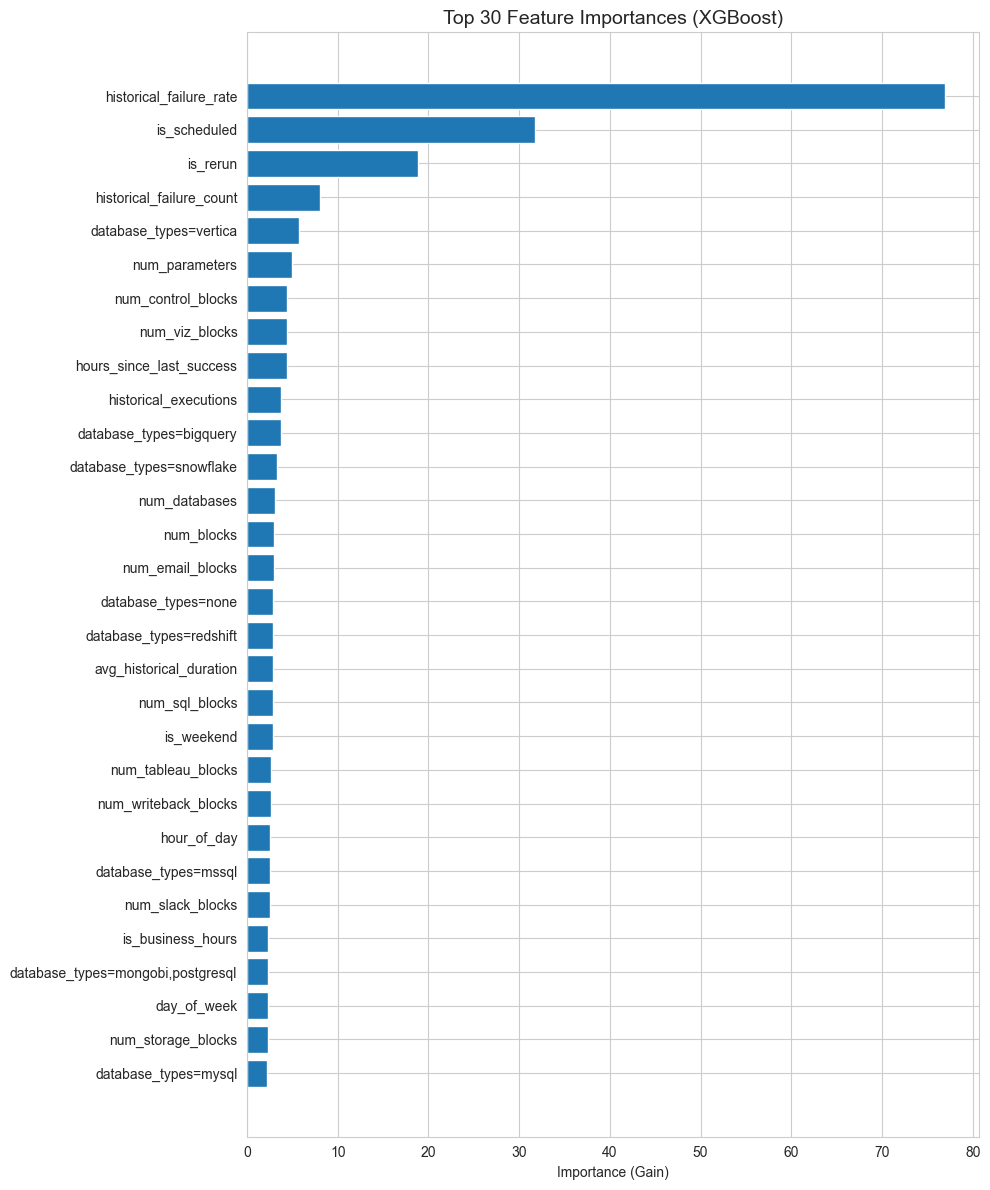

In [137]:
# Feature importance from final XGBoost model
importance_dict = final_xboost_model.get_score(importance_type='gain')
xgb_importance = pd.DataFrame([
    {'feature': k, 'importance': v}
    for k, v in importance_dict.items()
]).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features (XGBoost):")
print(xgb_importance.head(30))

# Plot
plt.figure(figsize=(10, 12))
top_features = xgb_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance (Gain)')
plt.title('Top 30 Feature Importances (XGBoost)', fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 12. Model Comparison


Model Comparison:
              Model  Train AUC  Validation AUC  Overfitting
Logistic Regression   0.964045        0.964543     0.000497
      Random Forest   0.999576        0.989272     0.010304
     XGBoost (best)   0.998071        0.987962     0.010108


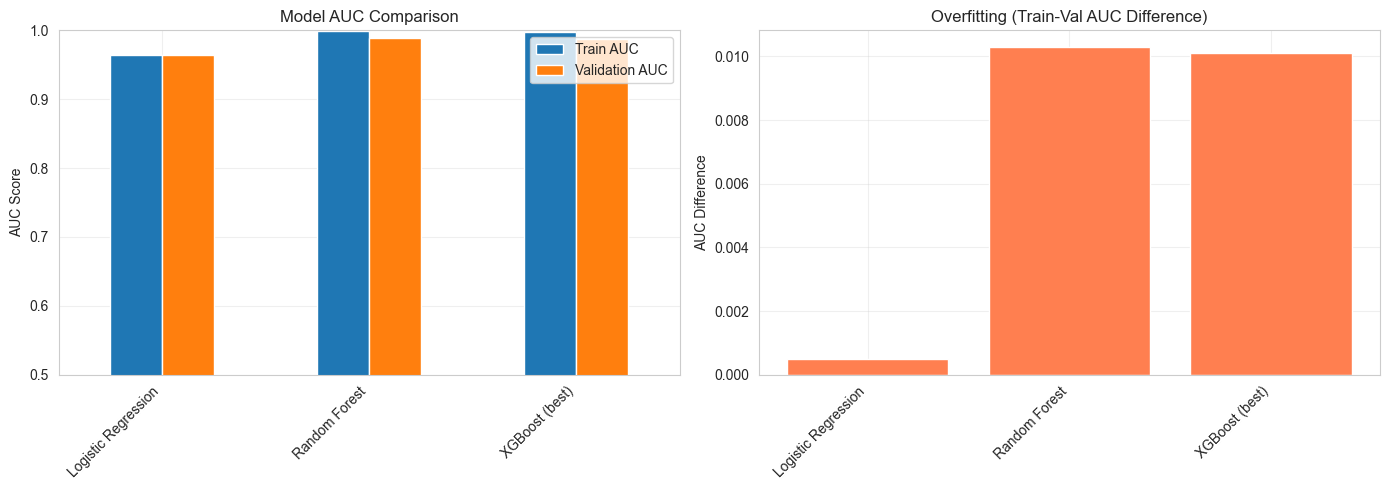

In [138]:
# Compare all models
comparison = pd.DataFrame([
    {
        'Model': 'Logistic Regression',
        'Train AUC': train_auc_lr,
        'Validation AUC': val_auc_lr,
        'Overfitting': abs(train_auc_lr - val_auc_lr)
    },
    {
        'Model': f"Random Forest",
        'Train AUC': train_auc_rf,
        'Validation AUC': val_auc_rf,
        'Overfitting': abs(train_auc_rf - val_auc_rf)
    },
    {
        'Model': f"XGBoost (best)",
        'Train AUC': final_xboost_train_auc,
        'Validation AUC': final_xboost_val_auc,
        'Overfitting': abs(final_xboost_train_auc - final_xboost_val_auc)
    }
])

print("\nModel Comparison:")
print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# AUC comparison
comparison.plot(x='Model', y=['Train AUC', 'Validation AUC'], kind='bar', ax=axes[0])
axes[0].set_title('Model AUC Comparison', fontsize=12)
axes[0].set_ylabel('AUC Score')
axes[0].set_xlabel('')
axes[0].set_ylim(0.5, 1.0)
axes[0].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Overfitting comparison
axes[1].bar(comparison['Model'], comparison['Overfitting'], color='coral')
axes[1].set_title('Overfitting (Train-Val AUC Difference)', fontsize=12)
axes[1].set_ylabel('AUC Difference')
axes[1].set_xlabel('')
axes[1].set_xticklabels(comparison['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. ROC Curve Analysis

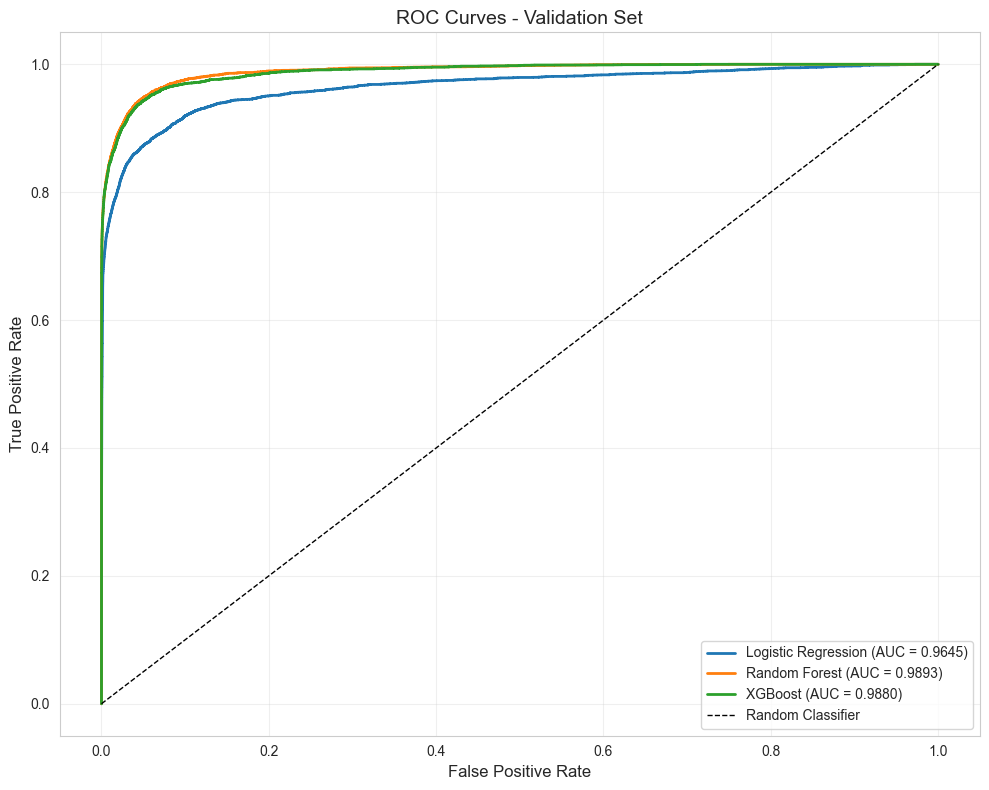

In [139]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_val_pred_lr)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {val_auc_lr:.4f})', linewidth=2)

# Best Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_val_pred_rf)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {val_auc_rf:.4f})", linewidth=2)

# Best XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, final_xgb_result['y_val_pred'])
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {final_xgb_result['val_auc']:.4f})", linewidth=2)

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Validation Set', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 14. Final Model Evaluation on Test Set

Using the best model (XGBoost) on the held-out test set.

FINAL MODEL EVALUATION ON TEST SET
Model: XGBoost
Parameters: max_depth=10, eta=0.1
Best iteration: 199

Results:
  Training AUC:   0.9981
  Validation AUC: 0.9880
  Test AUC:       0.9857

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

     Success       0.99      1.00      0.99     82830
     Failure       0.94      0.78      0.86      5532

    accuracy                           0.98     88362
   macro avg       0.96      0.89      0.92     88362
weighted avg       0.98      0.98      0.98     88362



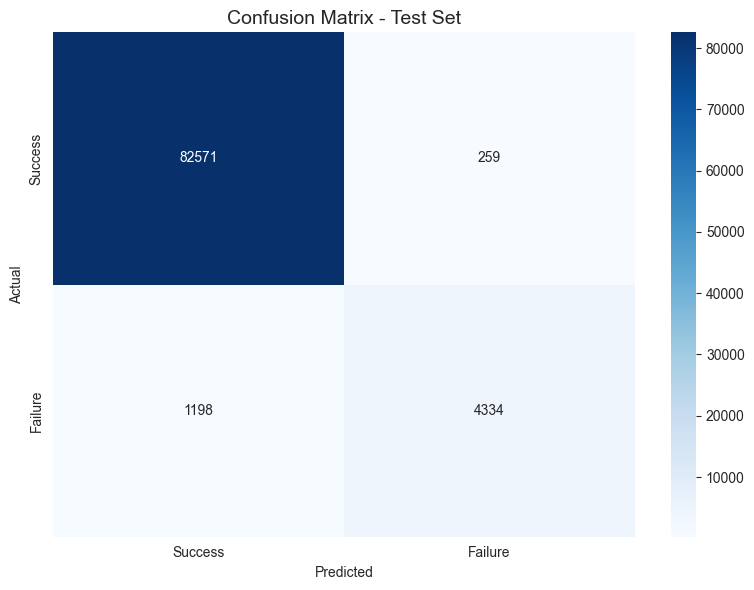

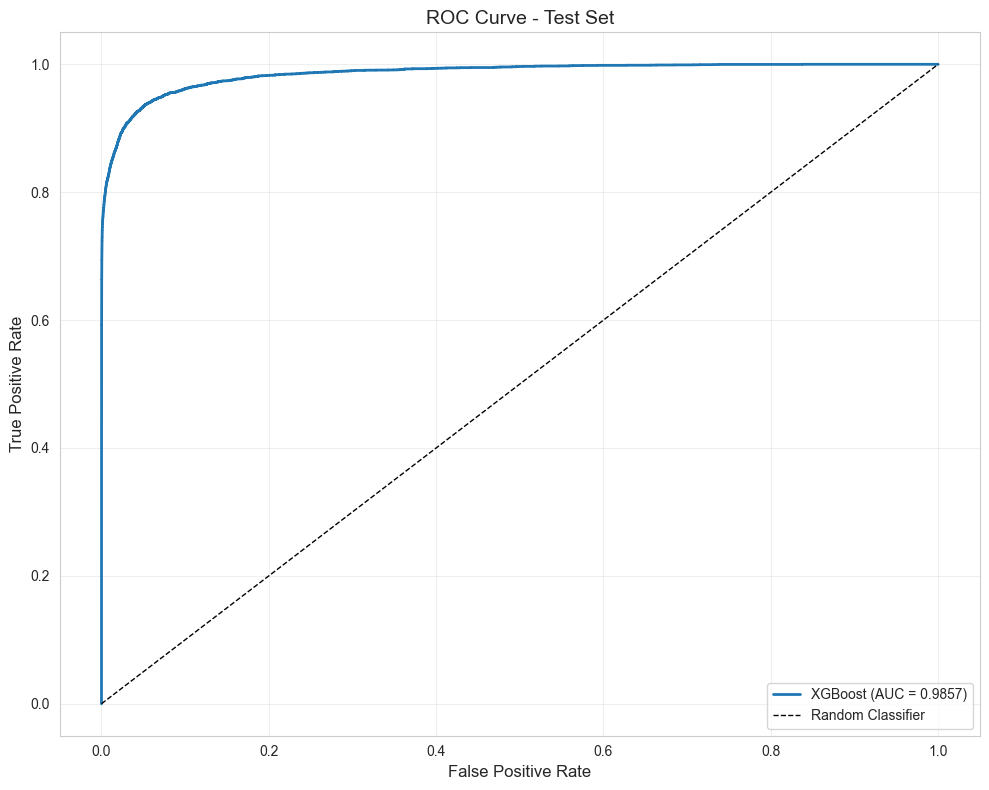

In [140]:
# Prepare test data for XGBoost
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.get_feature_names_out())

# Predictions on test set
y_test_pred = final_xgb_result['model'].predict(dtest)

# Evaluate
test_auc = roc_auc_score(y_test, y_test_pred)

print("="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)
print(f"Model: XGBoost")
print(f"Parameters: max_depth={final_xgb_result['params']['max_depth']}, eta={final_xgb_result['params']['eta']}")
print(f"Best iteration: {final_xgb_result['best_iteration']}")
print(f"\nResults:")
print(f"  Training AUC:   {final_xgb_result['train_auc']:.4f}")
print(f"  Validation AUC: {final_xgb_result['val_auc']:.4f}")
print(f"  Test AUC:       {test_auc:.4f}")
print("="*60)

# Classification report at threshold 0.5
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
print("\nClassification Report (threshold=0.5):")
print(classification_report(y_test, y_test_pred_binary, target_names=['Success', 'Failure']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Success', 'Failure'],
            yticklabels=['Success', 'Failure'])
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ROC curve for test set
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, linewidth=2, label=f'XGBoost (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Save the Model

Save the final model and DictVectorizer for deployment.

In [141]:
import pickle

# Save DictVectorizer
with open('dv.pkl', 'wb') as f:
    pickle.dump(dv, f)
print("DictVectorizer saved to 'dv.pkl'")

# Save XGBoost model
final_xgb_result['model'].save_model('model.xgb')
print("XGBoost model saved to 'model.xgb'")

# Save model metadata
model_info = {
    'model_type': 'XGBoost',
    'params': final_xgb_result['params'],
    'best_iteration': final_xgb_result['best_iteration'],
    'train_auc': final_xgb_result['train_auc'],
    'val_auc': final_xgb_result['val_auc'],
    'test_auc': test_auc,
    'feature_cols': feature_cols,
    'numerical_features': numerical_features,
    'categorical_features': categorical_features
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)
print("Model metadata saved to 'model_info.pkl'")

print("\nAll files saved successfully!")

DictVectorizer saved to 'dv.pkl'
XGBoost model saved to 'model.xgb'
Model metadata saved to 'model_info.pkl'

All files saved successfully!


## Summary

### Key Findings:

1. **Dataset**: 441,810 report executions with 6.13% failure rate
2. **Features**: 25 features including:
    - Report structure (13 block type counts)
    - Historical performance (5 metrics)
    - Timing features (6 features)
    - Database types (categorical)
3. **Best Model**: (eta=0.1, max_depth=10, min_child_weight=1)
    - Validation AUC: 0.9880
    - Test AUC: 0.9857
    - Minimal overfitting (0.0101 difference)
4. **Top Important Features**:
    - `historical_failure_rate` - strongest predictor
    - `historical_failure_count`
    - `hours_since_last_success`
    - `avg_historical_duration`
    - `num_sql_blocks`

### Model Comparison:

| Model | Train AUC | Val AUC | Test AUC | Overfitting |
|-------|-----------|---------|----------|-------------|
| Logistic Regression | 0.9640 | 0.9645 | - | 0.0005 |
| Random Forest | 0.9996 | 0.9893 | - | 0.0103 ⚠️ |
| **XGBoost (Final)** | 0.9981 | 0.9880 | 0.9857 | 0.0101 ✅ |

**Why XGBoost?**
- Best balance between performance and generalization
- Random Forest shows overfitting (99.96% train AUC)
- XGBoost achieves near-perfect performance with minimal overfitting